# Data preprocessing and Exploratory Data Analysis (EDA)

This notebook contains code related to the preprocessing of data and EDA.

### Methodology

The methodology used is an adaptation of Crisp-DM. Currently, we are the steps Data Understanding and  Data Preparation:
1. Domain Understanding
2. **Data Understanding**
4. **Data Preparation**
5. Modeling
6. Evaluation

Results of this notebook are used to select choose the approaches for following steps, Modeling and Evaluation.

### Importing necessary libraries

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
from sklearn.cluster import KMeans
from skrebate import SURF
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, scale
import re

### Constants

In [246]:
seed = 99 #Seed that control all random tasks

### Loading data 

This loads raw data available in the project repository.

In [247]:
#Raw data URL
data_url = "https://github.com/Naio/aasa-stability-prediction/blob/master/data/raw/aasa_1stn_4lys_1bpi.xlsx?raw=true"
p1STN = pd.read_excel(data_url, sheet_name='1STN')
p4LYZ = pd.read_excel(data_url, sheet_name='4LYZ')
p1BPI = pd.read_excel(data_url, sheet_name='1BPI')


#This dataset it is already preprocessed.
HLYZ = pd.read_csv('https://raw.githubusercontent.com/Naio/aasa-stability-prediction/master/data/processed/original/HLYZ.csv')

### Checking data integrity and usability

#### Conveniently renaming stability and protein name columns

In [248]:
def rename_columns(dataframe):
    return dataframe.rename(columns={'Unnamed: 0': 'id', 'Y': 'stability'})

In [249]:
p1STN = rename_columns(p1STN)
p4LYZ = rename_columns(p4LYZ)
p1BPI = rename_columns(p1BPI)

#### Standarizing names of columns

In the case of HLYZ dataset, descriptor names need to be standarized, because they follow a different format, for example AASA10pH instead of 10AASApH.

In [250]:
def standarize_descriptor_names(df):
    return df.rename(columns = {descriptor_name: standarize_descriptor_name(descriptor_name) 
                       for descriptor_name in df.columns[2:].tolist()})

def standarize_descriptor_name(descriptor_name):
    number = re.findall(r'^[0-9]+', descriptor_name)[0]
    property_name = re.sub(r'^[0-9]+AASA','', descriptor_name)
    return 'AASA' + number + property_name

In [251]:
p1STN = standarize_descriptor_names(p1STN)
p4LYZ = standarize_descriptor_names(p4LYZ)
p1BPI = standarize_descriptor_names(p1BPI)

#### Getting rid of apostrophes and points

In [252]:
def clean_columns_names(df):
    col_names = df.columns.tolist()
    return df.rename(columns={col_name: re.sub(r'[\'.]', '', col_name) for col_name in col_names})

In [253]:
p1STN = clean_columns_names(p1STN)
p4LYZ = clean_columns_names(p4LYZ)
p1BPI = clean_columns_names(p1BPI)
HLYZ = clean_columns_names(HLYZ)

Attributes names should be the same for all datasets.

In [254]:
HLYZ.columns.tolist() == p1STN.columns.tolist() ==  p4LYZ.columns.tolist() == p1BPI.columns.tolist()

True

#### Export cleaned dataset

In [200]:
original_data_path = '../../data/processed/original/'

In [201]:
p1STN.to_csv(path_or_buf = original_data_path + 'p1STN.csv', index=False)
p4LYZ.to_csv(path_or_buf = original_data_path + 'p4LYZ.csv', index=False)
p1BPI.to_csv(path_or_buf = original_data_path + 'p1BPI.csv', index=False)
HLYZ.to_csv(path_or_buf = original_data_path +  'HLYZ.csv', index=False)

### Checking for dataset metadata

For each dataset, there are 481 numeric columns, 10 for each of the 48 aminoacid properties and 1 for the **_stability change_**. Columns related to protein properties are called **_descriptors_**.

One row is the data for the **_wild-type_** protein, while the remaining rows are the data of the **_mutations_**. There's an additional column that contains the identifier for each row. The identifier is either **_WT_**, which stands for "wild-type", or a descriptive name for the mutation. The number of examples per dataset is:
 - 1STN: 42 examples
 - 4LYZ: 51 examples 
 - 1BPI: 53 examples

In [11]:
p1STN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Columns: 482 entries, id to 10AASAf
dtypes: float64(481), object(1)
memory usage: 158.3+ KB


In [12]:
p4LYZ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Columns: 482 entries, id to 10AASAf
dtypes: float64(481), object(1)
memory usage: 192.2+ KB


In [13]:
p1BPI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Columns: 482 entries, id to 10AASAf
dtypes: float64(481), object(1)
memory usage: 199.7+ KB


In [14]:
HLYZ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Columns: 482 entries, id to 10AASAf
dtypes: float64(481), object(1)
memory usage: 463.3+ KB


### Checking dataset summaries

In [75]:
p1STN.describe()

stability     AASA1K0     AASA2K0     AASA3K0     AASA4K0     AASA5K0  \
count  42.000000   42.000000   42.000000   42.000000   42.000000   42.000000   
mean   -2.202857  944.768915  948.316498  947.214726  946.506837  947.941768   
std     1.701693    1.952212    1.999672    2.012307    1.984603    1.950409   
min    -5.400000  941.412679  944.512043  943.462118  943.343903  944.346386   
25%    -3.550000  943.218628  946.700855  945.625794  944.954999  946.364477   
50%    -2.300000  943.990719  947.615727  946.484195  945.815640  947.209256   
75%    -1.025000  946.539910  950.173852  949.025680  948.315176  949.678510   
max     0.700000  948.094815  951.617217  950.709249  949.696070  951.062389   

          AASA6K0     AASA7K0     AASA8K0     AASA9K0  ...     AASA1f  \
count   42.000000   42.000000   42.000000   42.000000  ...  42.000000   
mean   948.023895  946.536467  946.218975  947.187120  ...   3.697188   
std      2.045103    2.023888    2.009083    2.108097  ...   0.039475   
min    944.482133  942.919672  943.062796  943.573289  ...   3.624161   
25%    946.446324  944.865673  944.615359  945.565415  ...   3.664430   
50%    947.285869  945.845815  945.403712  946.313589  ...   3.711409   
75%    949.884030  948.350516  948.085189  949.121333  ...   3.718121   
max    951.496366  950.091950  949.824236  950.594113  ...   3.765101   

          AASA2f     AASA3f     AASA4f     AASA5f     AASA6f     AASA7f  \
count  42.000000  42.000000  42.000000  42.000000  42.000000  42.000000   
mean    3.921815   4.087949   3.908187   3.958456   3.878803   3.772894   
std     0.043486   0.036383   0.038806   0.040170   0.032760   0.038558   
min     3.810811   3.986395   3.821918   3.855172   3.819444   3.678322   
25%     3.885135   4.054422   3.885274   3.937931   3.850694   3.748252   
50%     3.925676   4.085034   3.921233   3.965517   3.881944   3.790210   
75%     3.952703   4.108844   3.931507   3.979310   3.902778   3.790210   
max     4.000000   4.156463   3.972603   4.020690   3.937500   3.839161   

          AASA8f     AASA9f    AASA10f  
count  42.000000  42.000000  42.000000  
mean    4.224346   3.875211   4.155442  
std     0.045945   0.044001   0.047059  
min     4.084507   3.794326   4.057143  
25%     4.197183   3.833333   4.114286  
50%     4.228873   3.893617   4.171429  
75%     4.253521   3.900709   4.185714  
max     4.316901   3.943262   4.235714  

[8 rows x 481 columns]

### Checking example duplicates

#### Example duplicates based on all columns

In [15]:
print("Number of duplicated examples per dataset:")
print("  p1STN:", p1STN.duplicated().sum())
print("  p4LYZ:", p4LYZ.duplicated().sum())
print("  p1BPI:", p1BPI.duplicated().sum())
print("  HLYZ:", HLYZ.duplicated().sum())

Number of duplicated examples per dataset:
  p1STN: 0
  p4LYZ: 0
  p1BPI: 0
  HLYZ: 0


#### Checking number of distinct values in stability column

In [108]:
print("% of distinct values in the stability column:")
print("  p1STN:", (len(p1STN['stability'].value_counts())*100)/len(p1STN))
print("  p4LYZ:", (len(p4LYZ['stability'].value_counts())*100)/len(p4LYZ))
print("  p1BPI:", (len(p1BPI['stability'].value_counts())*100)/len(p1BPI))
print("  HLYZ:", (len(HLYZ['stability'].value_counts())*100)/len(HLYZ))

% of distinct values in the stability column:
  p1STN: 78.57142857142857
  p4LYZ: 80.3921568627451
  p1BPI: 64.15094339622641
  HLYZ: 70.73170731707317


Percentages are relatively high, so is safe to assume that the variable is continuous

#### Example duplicates based on stability

In [359]:
def stability_duplicates(df):
    return df[df.duplicated(subset=['stability'], keep=False)]

In [360]:
stability_duplicates(p1STN).sort_values(by='stability', ascending=True)

id  stability     1AASAK0     2AASAK0     3AASAK0     4AASAK0  \
3   F61G       -4.7  943.010422  946.282655  945.351124  944.149768   
4   F76G       -4.7  942.374836  946.244955  945.080812  944.303151   
8   L37G       -3.9  943.842150  947.606872  946.120860  945.583058   
9   D83A       -3.9  942.627091  946.282457  945.231491  944.829458   
10  L36A       -3.6  943.419766  946.641450  945.678661  944.862200   
11  D95A       -3.6  943.196289  945.984865  945.057320  944.202634   
18  I18G       -2.6  944.000628  947.537109  946.210607  945.565051   
17  L25A       -2.6  943.201441  946.670728  945.602618  945.041997   
20  F61A       -2.4  942.439315  945.651439  944.760307  943.457816   
21  T62A       -2.4  943.306919  947.213900  945.940867  945.425463   
26  A60G       -1.5  946.529712  950.030535  949.020654  948.199727   
27  V23F       -1.5  947.555213  951.174542  949.872427  949.457225   
30  L89F       -1.2  946.853672  950.604885  949.424585  948.951647   
29  G79S       -1.2  947.137564  950.618077  949.609516  948.994797   
0     WT        0.0  945.881189  949.455569  948.320961  947.627981   
37  F76V        0.0  944.058257  947.786391  946.636427  945.899422   
38  H46Y        0.0  947.065152  950.818455  949.799647  948.719025   

       5AASAK0     6AASAK0     7AASAK0     8AASAK0  ...    1AASAf    2AASAf  \
3   946.203153  945.855203  944.161602  944.331529  ...  3.704698  3.885135   
4   945.935353  945.831117  944.545984  944.044796  ...  3.651007  3.885135   
8   947.210080  947.190441  945.503238  945.406416  ...  3.664430  3.871622   
9   945.882821  945.728563  944.437522  943.586278  ...  3.651007  3.858108   
10  946.644846  946.727174  944.862678  944.591878  ...  3.624161  3.898649   
11  946.040476  945.567167  944.839304  944.272078  ...  3.718121  3.871622   
18  946.965476  947.240897  945.797392  945.138804  ...  3.691275  3.898649   
17  946.423097  946.704497  944.871900  944.897033  ...  3.624161  3.912162   
20  945.645877  945.197183  943.470238  943.719909  ...  3.704698  3.885135   
21  946.145716  947.008136  945.533185  944.685801  ...  3.677852  3.925676   
26  949.606255  949.846501  948.356122  948.114423  ...  3.718121  3.952703   
27  950.739466  950.592022  949.418675  948.925075  ...  3.751678  3.979730   
30  950.106490  950.432455  948.760736  948.553087  ...  3.718121  3.952703   
29  950.256101  950.586455  948.820678  948.602963  ...  3.765101  4.000000   
0   949.004393  949.162855  947.636857  947.405937  ...  3.718121  3.952703   
37  947.408818  947.430705  946.029931  945.658501  ...  3.684564  3.918919   
38  950.356562  950.688197  949.033873  948.896954  ...  3.718121  3.952703   

      3AASAf    4AASAf    5AASAf    6AASAf    7AASAf    8AASAf    9AASAf  \
3   4.054422  3.849315  3.965517  3.861111  3.734266  4.197183  3.801418   
4   4.068027  3.863014  3.855172  3.833333  3.762238  4.169014  3.829787   
8   4.054422  3.904110  3.937931  3.861111  3.734266  4.197183  3.815603   
9   4.068027  3.863014  3.924138  3.847222  3.762238  4.183099  3.858156   
10  4.081633  3.863014  3.965517  3.861111  3.748252  4.183099  3.815603   
11  4.040816  3.890411  3.951724  3.833333  3.790210  4.154930  3.886525   
18  4.054422  3.890411  3.951724  3.847222  3.762238  4.169014  3.815603   
17  4.040816  3.904110  3.937931  3.875000  3.720280  4.239437  3.815603   
20  4.054422  3.849315  3.965517  3.861111  3.734266  4.197183  3.801418   
21  4.081633  3.924658  3.937931  3.888889  3.790210  4.211268  3.843972   
26  4.108844  3.931507  3.979310  3.902778  3.790210  4.253521  3.900709   
27  4.129252  3.958904  4.020690  3.902778  3.839161  4.267606  3.936170   
30  4.108844  3.931507  3.979310  3.902778  3.790210  4.253521  3.900709   
29  4.129252  3.965753  4.013793  3.937500  3.804196  4.316901  3.929078   
0   4.108844  3.931507  3.979310  3.902778  3.790210  4.253521  3.900709   
37  4.088435  3.897260  3.917241  3.868056  3.776224  4.211268  3.865248   
38  4.108844

In [361]:
stability_duplicates(p4LYZ).sort_values(by='stability', ascending=True)

id  stability     1AASAK0     2AASAK0     3AASAK0     4AASAK0  \
17   I55L      -0.45  901.528988  901.859757  900.905761  901.405054   
18  Q121H      -0.45  901.198359  901.483557  900.528693  901.081632   
19    F3Y      -0.45  901.738922  902.076471  901.027220  901.539974   
20   G71A      -0.38  900.911198  901.181827  900.226391  900.705292   
21   N77H      -0.38  901.999717  902.263884  901.377389  901.826562   
24   R21Q      -0.15  904.403560  904.938990  903.872217  904.421632   
25   S91A      -0.15  899.623519  899.733746  898.677824  899.367311   
26  D101Q      -0.08  901.299705  901.609832  900.665087  901.142660   
27   S91V      -0.08  901.850917  902.218946  901.282170  901.749330   
28   R68K      -0.04  904.138053  904.405215  903.540894  904.281292   
29  G102V      -0.04  903.325519  903.468395  902.667304  903.205860   
31  D101E       0.00  902.873826  903.325663  902.317406  902.944094   
0      WT       0.00  901.528988  901.859757  900.905761  901.405054   
30   I55V       0.00  901.000424  901.247041  900.312973  900.833063   
34   F34Y       0.19  901.778817  902.063105  901.114485  901.656317   
35  D101K       0.19  901.211519  901.513707  900.572520  901.041740   
44  D101A       0.76  898.169100  898.197395  897.378961  897.559978   
45   H15L       0.76  901.504049  901.829673  900.875383  901.378197   

       5AASAK0     6AASAK0     7AASAK0     8AASAK0  ...    1AASAf    2AASAf  \
17  905.565316  902.511846  900.558848  901.044779  ...  2.899225  3.000000   
18  905.204164  902.109536  900.229885  900.654313  ...  2.891473  2.968750   
19  905.684809  902.608499  900.656287  901.143016  ...  2.899225  3.000000   
20  904.774036  901.764265  899.771043  900.387115  ...  2.899225  3.000000   
21  905.981774  902.957436  900.979402  901.515626  ...  2.899225  3.000000   
24  908.148676  905.537533  903.323261  904.133792  ...  2.868217  2.937500   
25  903.383025  900.311956  898.295492  898.804516  ...  2.891473  2.976562   
26  905.301988  902.297975  900.292253  900.782562  ...  2.906977  3.023438   
27  905.934014  902.883517  900.941241  901.423270  ...  2.899225  3.000000   
28  908.194522  905.361759  903.303173  904.015320  ...  2.891473  2.984375   
29  907.242100  904.340530  902.210510  902.775257  ...  2.930233  3.007812   
31  907.109836  903.766281  902.122531  902.582779  ...  2.906977  3.023438   
0   905.565316  902.511846  900.558848  901.044779  ...  2.899225  3.000000   
30  905.010743  902.010240  899.961307  900.460310  ...  2.883721  2.960938   
34  905.796631  902.744837  900.801490  901.247033  ...  2.899225  3.000000   
35  905.200708  902.215717  900.189716  900.681710  ...  2.914729  3.046875   
44  901.706548  899.377814  896.652204  897.202300  ...  2.883721  2.953125   
45  905.536271  902.486627  900.530175  901.009772  ...  2.899225  3.000000   

      3AASAf    4AASAf  5AASAf    6AASAf    7AASAf    8AASAf    9AASAf  \
17  2.645669  3.055556   2.928  2.790323  3.227642  2.852459  3.041322   
18  2.622047  3.015873   2.896  2.774194  3.146341  2.819672  3.000000   
19  2.645669  3.055556   2.928  2.790323  3.227642  2.852459  3.041322   
20  2.645669  3.055556   2.928  2.790323  3.227642  2.852459  3.041322   
21  2.645669  3.055556   2.928  2.790323  3.227642  2.852459  3.041322   
24  2.598425  2.992063   2.928  2.725806  3.113821  2.770492  2.975207   
25  2.622047  3.039683   2.888  2.750000  3.195122  2.827869  3.033058   
26  2.661417  3.111111   2.976  2.790323  3.252033  2.877049  3.049587   
27  2.645669  3.055556   2.928  2.790323  3.227642  2.852459  3.041322   
28  2.629921  3.039683   2.872  2.758065  3.170732  2.836066  3.008264   
29  2.677165  3.087302   2.960  2.838710  3.235772  2.860656  3.074380   
31  2.661417  3.111111   2.976  2.790323  3.252033  2.877049  3.049587   
0   2.645669  3.055556   2.928  2.790323  3.227642  2.852459  3.041322   
30  2.614173  3.031746   2.912  2.750000  3.195122  2.827869  3.016529   
34  2.645669  3.055556   2

In [213]:
stability_duplicates(p1BPI).sort_values(by='stability', ascending=True)

id  stability     1AASAK0     2AASAK0     3AASAK0     4AASAK0  \
15  I19A       -2.1  892.413010  892.711412  896.337375  892.036669   
16  G36A       -2.1  897.132614  897.832051  901.432218  898.186484   
17  R20A       -1.8  897.446583  898.198395  901.837832  898.585156   
18  G12A       -1.8  897.327355  897.716525  901.579807  898.404120   
21  I18A       -1.5  892.413010  893.759181  895.510882  892.042378   
22   E7A       -1.5  888.612698  889.005614  889.818673  887.249765   
24  Y10A       -1.2  889.803479  891.117709  892.979643  888.563738   
25  V34A       -1.2  892.596734  894.271040  897.621289  893.623178   
26  P13A       -1.2  901.056924  902.013235  905.501638  901.773802   
27  F22A       -1.2  887.822859  890.379054  893.823804  889.184807   
30  G28A       -1.0  897.254941  897.785209  901.514182  898.039211   
29  Q31A       -1.0  890.895717  891.240612  895.765039  891.922375   
34  R42A       -0.5  897.513976  898.393314  901.847232  898.405549   
35   R1A       -0.5  898.287355  898.850746  902.379632  899.065331   
36  K41A       -0.4  892.535838  892.538577  895.219218  892.013193   
37  K15A       -0.4  891.798252  893.464630  895.827896  891.828775   
38  D50A       -0.4  889.672462  891.924304  895.382396  890.918018   
39  R17A       -0.3  897.630224  898.240444  901.881632  898.547280   
40   P8A       -0.3  901.041407  902.137972  905.643870  902.251211   
41  E49A       -0.2  887.952262  887.764525  890.956171  887.868625   
42  G56A       -0.2  897.189252  898.008630  902.357396  898.883302   
43  G57A       -0.2  897.378562  898.637840  902.233914  899.007665   
44  R53A       -0.1  897.531162  898.211756  901.868032  898.447295   
45  T32A       -0.1  892.103352  893.124135  896.236384  894.107847   
46  T54A       -0.1  892.864059  893.652904  896.949564  893.626527   
48  L29A        0.0  892.259259  893.100332  895.934782  892.878189   
0     WT        0.0  898.736321  899.501525  903.070432  899.733665   
49  K26A        0.0  892.669079  892.492577  894.840950  891.283047   
47  R39A        0.0  897.610141  898.334367  901.998032  898.391498   
50  T11A        0.0  892.610160  894.827051  897.333270  892.589918   

       5AASAK0     6AASAK0     7AASAK0     8AASAK0  ...    1AASAf    2AASAf  \
15  887.324150  887.807532  885.544790  889.331404  ...  2.637931  2.982456   
16  892.928994  891.901683  890.910406  894.614039  ...  2.879310  3.228070   
17  893.533661  892.205713  891.668483  895.131098  ...  2.534483  2.877193   
18  892.990383  891.785079  890.855021  894.518157  ...  2.879310  3.228070   
21  887.959128  886.723343  885.867244  888.016298  ...  2.637931  3.052632   
22  884.805522  883.544081  885.984071  889.538392  ...  2.775862  3.175439   
24  883.248583  882.810732  881.792956  886.055504  ...  2.844828  3.228070   
25  889.197365  888.512249  887.017560  890.391835  ...  2.810345  3.210526   
26  897.027467  896.468617  895.245406  899.309480  ...  2.879310  3.228070   
27  886.009276  884.629230  881.561037  884.681969  ...  2.741379  2.982456   
30  892.802606  891.739796  890.698675  894.739922  ...  2.879310  3.228070   
29  886.924550  886.550928  884.018252  887.737118  ...  2.775862  3.017544   
34  893.554817  892.474513  891.185375  894.917200  ...  2.362069  3.052632   
35  894.075409  892.819600  892.217713  895.806392  ...  2.879310  3.052632   
36  887.144550  885.136004  885.271790  886.750333  ...  2.534483  2.736842   
37  886.859606  885.999155  885.050194  886.686745  ...  2.810345  2.877193   
38  885.229306  885.259457  884.233906  888.529639  ...  2.741379  3.122807   
39  893.458165  892.184158  891.298883  895.246392  ...  2.706897  2.701754   
40  897.083300  895.964277  895.272233  897.441980  ...  2.879310  3.228070   
41  882.458122  880.755789  881.716071  883.889569  ...  2.775862  3.122807   
42  893.822883  892.646589  891.675117  895.566980  ...  2.879310  3.228070   
43  893.868439  892.655079  891.763098  895.253157  ...  2.879310 

#### Checking if descriptors are continuous

Descriptors are numerical. However, numbers could be , This is an important information to have before preprocessing and selecting training algorithms.

In [152]:
def proportion_of_unique_values_per_column(df):
    distinct_values_per_column = df.nunique()
    return (distinct_values_per_column/len(df))

#Returns a list of columns which proportion of distinct values with 
#respect of the number of observations is below some threshold.
def discrete_columns(df, distinct_threshold):
    #Those columns which proportion of distinct values is below some threshold, are considered discrete.
    discrete_columns = df.columns[proportion_of_unique_values_per_column(df) < distinct_threshold]
    return discrete_columns.to_list()

It is considered that a proportion of distinct values below 20% of the total of values indicate that the column is discrete.

In [259]:
discrete_columns(p1STN, distinct_threshold=0.3)

['AASA1s',
 'AASA3s',
 'AASA4s',
 'AASA5s',
 'AASA6s',
 'AASA7s',
 'AASA8s',
 'AASA9s',
 'AASA10s',
 'AASA3f']

In [256]:
p1STN['AASA1s'].value_counts()

1.382550    17
1.369128    11
1.315436     2
1.288591     2
1.328859     2
1.355705     2
1.342282     1
1.429530     1
1.402685     1
1.348993     1
1.389262     1
1.395973     1
Name: AASA1s, dtype: int64

In [155]:
discrete_columns(p4LYZ, distinct_threshold=0.3)

['AASA1s',
 'AASA3s',
 'AASA4s',
 'AASA5s',
 'AASA6s',
 'AASA7s',
 'AASA8s',
 'AASA9s',
 'AASA10s',
 'AASA1f',
 'AASA3f',
 'AASA6f']

In [156]:
discrete_columns(p1BPI, distinct_threshold=0.3)

['AASA1s',
 'AASA2s',
 'AASA3s',
 'AASA4s',
 'AASA5s',
 'AASA6s',
 'AASA7s',
 'AASA8s',
 'AASA9s',
 'AASA10s',
 'AASA1f',
 'AASA6f',
 'AASA8f',
 'AASA10f']

In [157]:
discrete_columns(HLYZ, distinct_threshold=0.3)

['AASA1s',
 'AASA2s',
 'AASA3s',
 'AASA4s',
 'AASA5s',
 'AASA6s',
 'AASA7s',
 'AASA8s',
 'AASA9s',
 'AASA10s',
 'AASA1f',
 'AASA2f',
 'AASA3f',
 'AASA4f',
 'AASA5f',
 'AASA6f',
 'AASA7f',
 'AASA8f',
 'AASA9f',
 'AASA10f']

### Checking for missing values

There's no missing values in any dataset.

In [19]:
def number_of_missing_values(dataframe):
    return (
    dataframe.isnull() #Checks dataframe cell if it has a missing value. Returns a dataframe filled with boolean values. 
    .sum() # Returns the number of missing values per column.
    .sum() # Outputs the number of missing values of the whole dataframe.
    )

In [20]:
print("Number of missing values per dataset:")
print("  p1STN:", number_of_missing_values(p1STN))
print("  p4LYZ:", number_of_missing_values(p4LYZ))
print("  p1BPI:", number_of_missing_values(p1BPI))
print("  p1BPI:", number_of_missing_values(HLYZ))

Number of missing values per dataset:
  p1STN: 0
  p4LYZ: 0
  p1BPI: 0
  p1BPI: 0


### Correlation between stability and descriptors

The predictors that are the most correlated to the target value can be useful as explanatory variables for predictive modeling.

In [76]:
def most_correlated_descriptors(df, n):
    return df.corr(method='pearson')['stability'][1:].abs().sort_values(ascending=False).head(n)

In [84]:
most_correlated_descriptors(p1STN, n=10).round(decimals=2)

AASA2ASAD     0.72
AASA10V0      0.72
AASA2V0       0.71
AASA10ASAD    0.71
AASA6ASAD     0.70
AASA10DASA    0.70
AASA8V0       0.70
AASA10Ca      0.69
AASA10Mw      0.69
AASA2DASA     0.69
Name: stability, dtype: float64

In [161]:
px.scatter(p1STN, x = 'AASA2ASAD', y =  'stability', title = "Stability vs AASA2ASAD from Dataset 1STN", 
           labels={'x': 'AASA2ASAD', 'y':'Stability'}, trendline="ols", hover_data=['id'] )

In [83]:
most_correlated_descriptors(p4LYZ, n=10).round(decimals=2)

AASA3ac       0.54
AASA10DCph    0.52
AASA1Ns       0.52
AASA7ac       0.52
AASA6Ns       0.52
AASA2Ns       0.51
AASA5Ns       0.51
AASA9Ns       0.50
AASA4Ns       0.50
AASA5ac       0.49
Name: stability, dtype: float64

In [164]:
px.scatter(p4LYZ, x= 'AASA3ac', y =  'stability', title = "Stability vs AASA3ac from Dataset 4LYZ", 
           labels={'x': 'AASA3ac', 'y':'Stability'}, trendline="ols", hover_data=['id'])

In [82]:
most_correlated_descriptors(p1BPI, n=10).round(decimals=2)

AASA8m       0.73
AASA10m      0.72
AASA9m       0.70
AASA8Hgm     0.68
AASA10Hgm    0.67
AASA3Hgm     0.67
AASA7Hgm     0.67
AASA1Hgm     0.67
AASA2Hgm     0.66
AASA9Hgm     0.66
Name: stability, dtype: float64

In [37]:
px.scatter(p1BPI, x = 'AASA8m', y =  'stability', title = "Stability vs AASA8m from Dataset p1BPI", 
           labels={'x': 'AASA8m', 'y':'Stability'}, trendline="ols", hover_data=['id'])

In [81]:
most_correlated_descriptors(HLYZ, n=10).round(decimals=2)

AASA3DCph    0.46
AASA5Rf      0.44
AASA5DCph    0.43
AASA5Ht      0.43
AASA8Ht      0.43
AASA3Ht      0.43
AASA3Ra      0.43
AASA3DASA    0.42
AASA2pK      0.42
AASA5pK      0.41
Name: stability, dtype: float64

In [40]:
px.scatter(HLYZ, x = 'AASA3DCph', y =  'stability', title = "Stability vs AASA3DCph from Dataset HLYZ", 
           labels={'x': 'AASA3DCph', 'y':'Stability'}, trendline="ols", hover_data=['id'])

### Correlation between descriptors

In [165]:
#Returns the number of descriptors that have a high Pearson's correlation with other descriptors.
def highly_correlated_descriptors_per_threshold(df):
    return {str(t):number_of_highly_correlated_descriptors(df, threshold=t) 
            for t in [0.99,0.98,0.96,0.95,0.94,0.93, 0.92, 0.91, 0.90]}


#Returns the number of descriptors that have a Pearson's correlation coef. above some threshold with at least one other descriptor.
def number_of_highly_correlated_descriptors(df, threshold):
    correlations = df.corr().abs()
    upper_corr = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper_corr.columns if any(upper_corr[column] > threshold)]
    return len(to_drop)



The following is interpreted like this: *_ For the dataset 1STN, there are 78 descriptors that have a Pearson's correlation above 0.99 with at least one other descriptor. In the same way, there are 339 descriptors that have a Pearson's correlation above 0.90 with at least one other descriptor._*

In [86]:
highly_correlated_descriptors_per_threshold(p1STN)

{'0.99': 78,
 '0.98': 109,
 '0.96': 211,
 '0.95': 245,
 '0.94': 266,
 '0.93': 285,
 '0.92': 305,
 '0.91': 328,
 '0.9': 339}

In [87]:
highly_correlated_descriptors_per_threshold(p4LYZ)

{'0.99': 89,
 '0.98': 129,
 '0.96': 205,
 '0.95': 236,
 '0.94': 255,
 '0.93': 277,
 '0.92': 298,
 '0.91': 315,
 '0.9': 335}

In [152]:
highly_correlated_descriptors_per_threshold(p1BPI)

{'0.99': 34,
 '0.98': 83,
 '0.96': 157,
 '0.95': 183,
 '0.94': 211,
 '0.93': 237,
 '0.92': 254,
 '0.91': 273,
 '0.9': 296}

In [153]:
highly_correlated_descriptors_per_threshold(HLYZ)

{'0.99': 77,
 '0.98': 128,
 '0.96': 190,
 '0.95': 221,
 '0.94': 249,
 '0.93': 278,
 '0.92': 303,
 '0.91': 318,
 '0.9': 337}

In [270]:
p = re.compile('^AASA5')
columns = [ column for column in p1STN.iloc[:,2:].columns if p.match(column) ]

['AASA5K0', 'AASA5Ht', 'AASA5HP', 'AASA5P', 'AASA5pHi', 'AASA5pK']

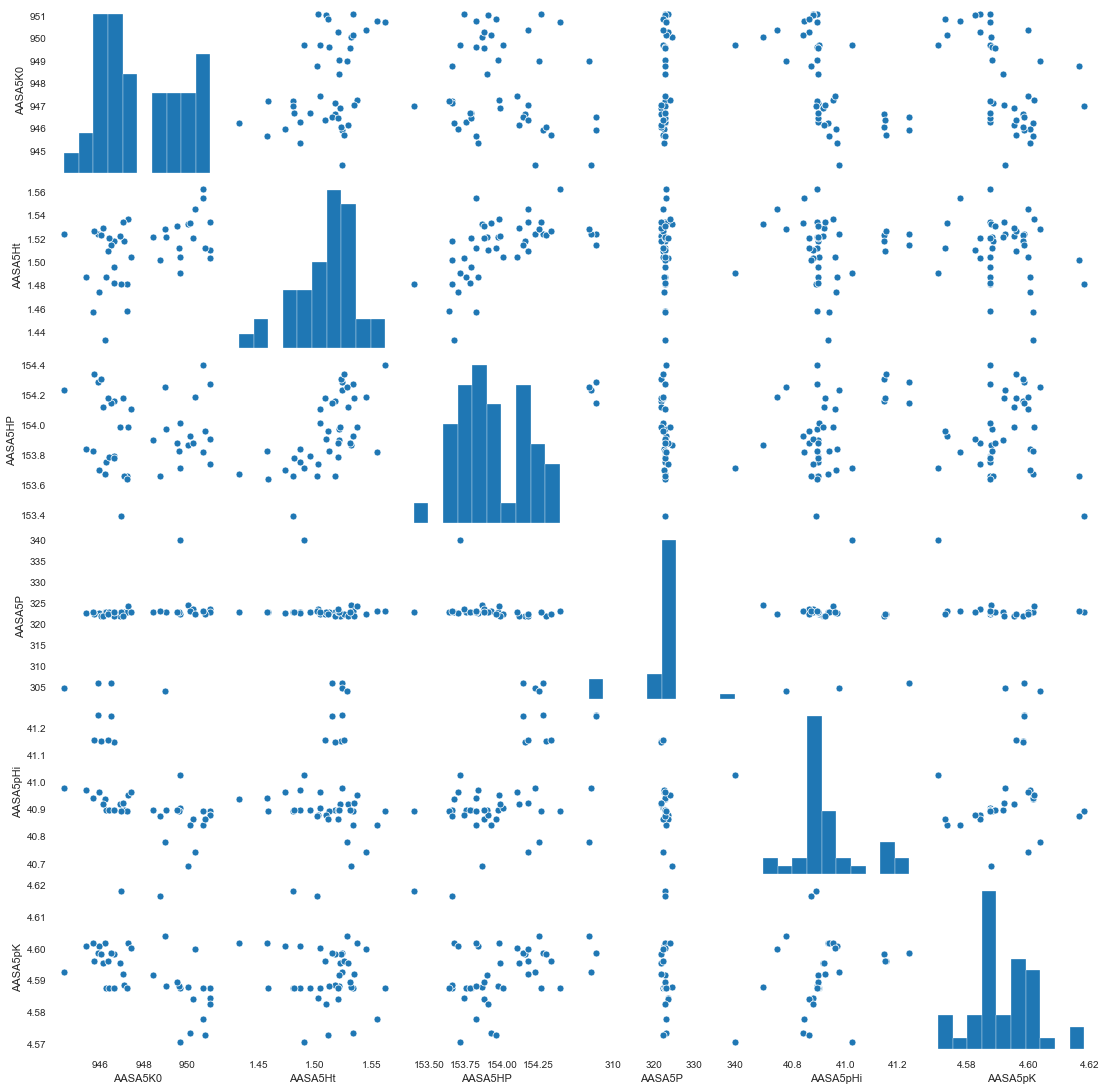

In [274]:
sns_plot = sns.pairplot(p1STN.loc[:,columns[:6]])
sns_plot.savefig("interproperty1STN.png")

KeyboardInterrupt: 

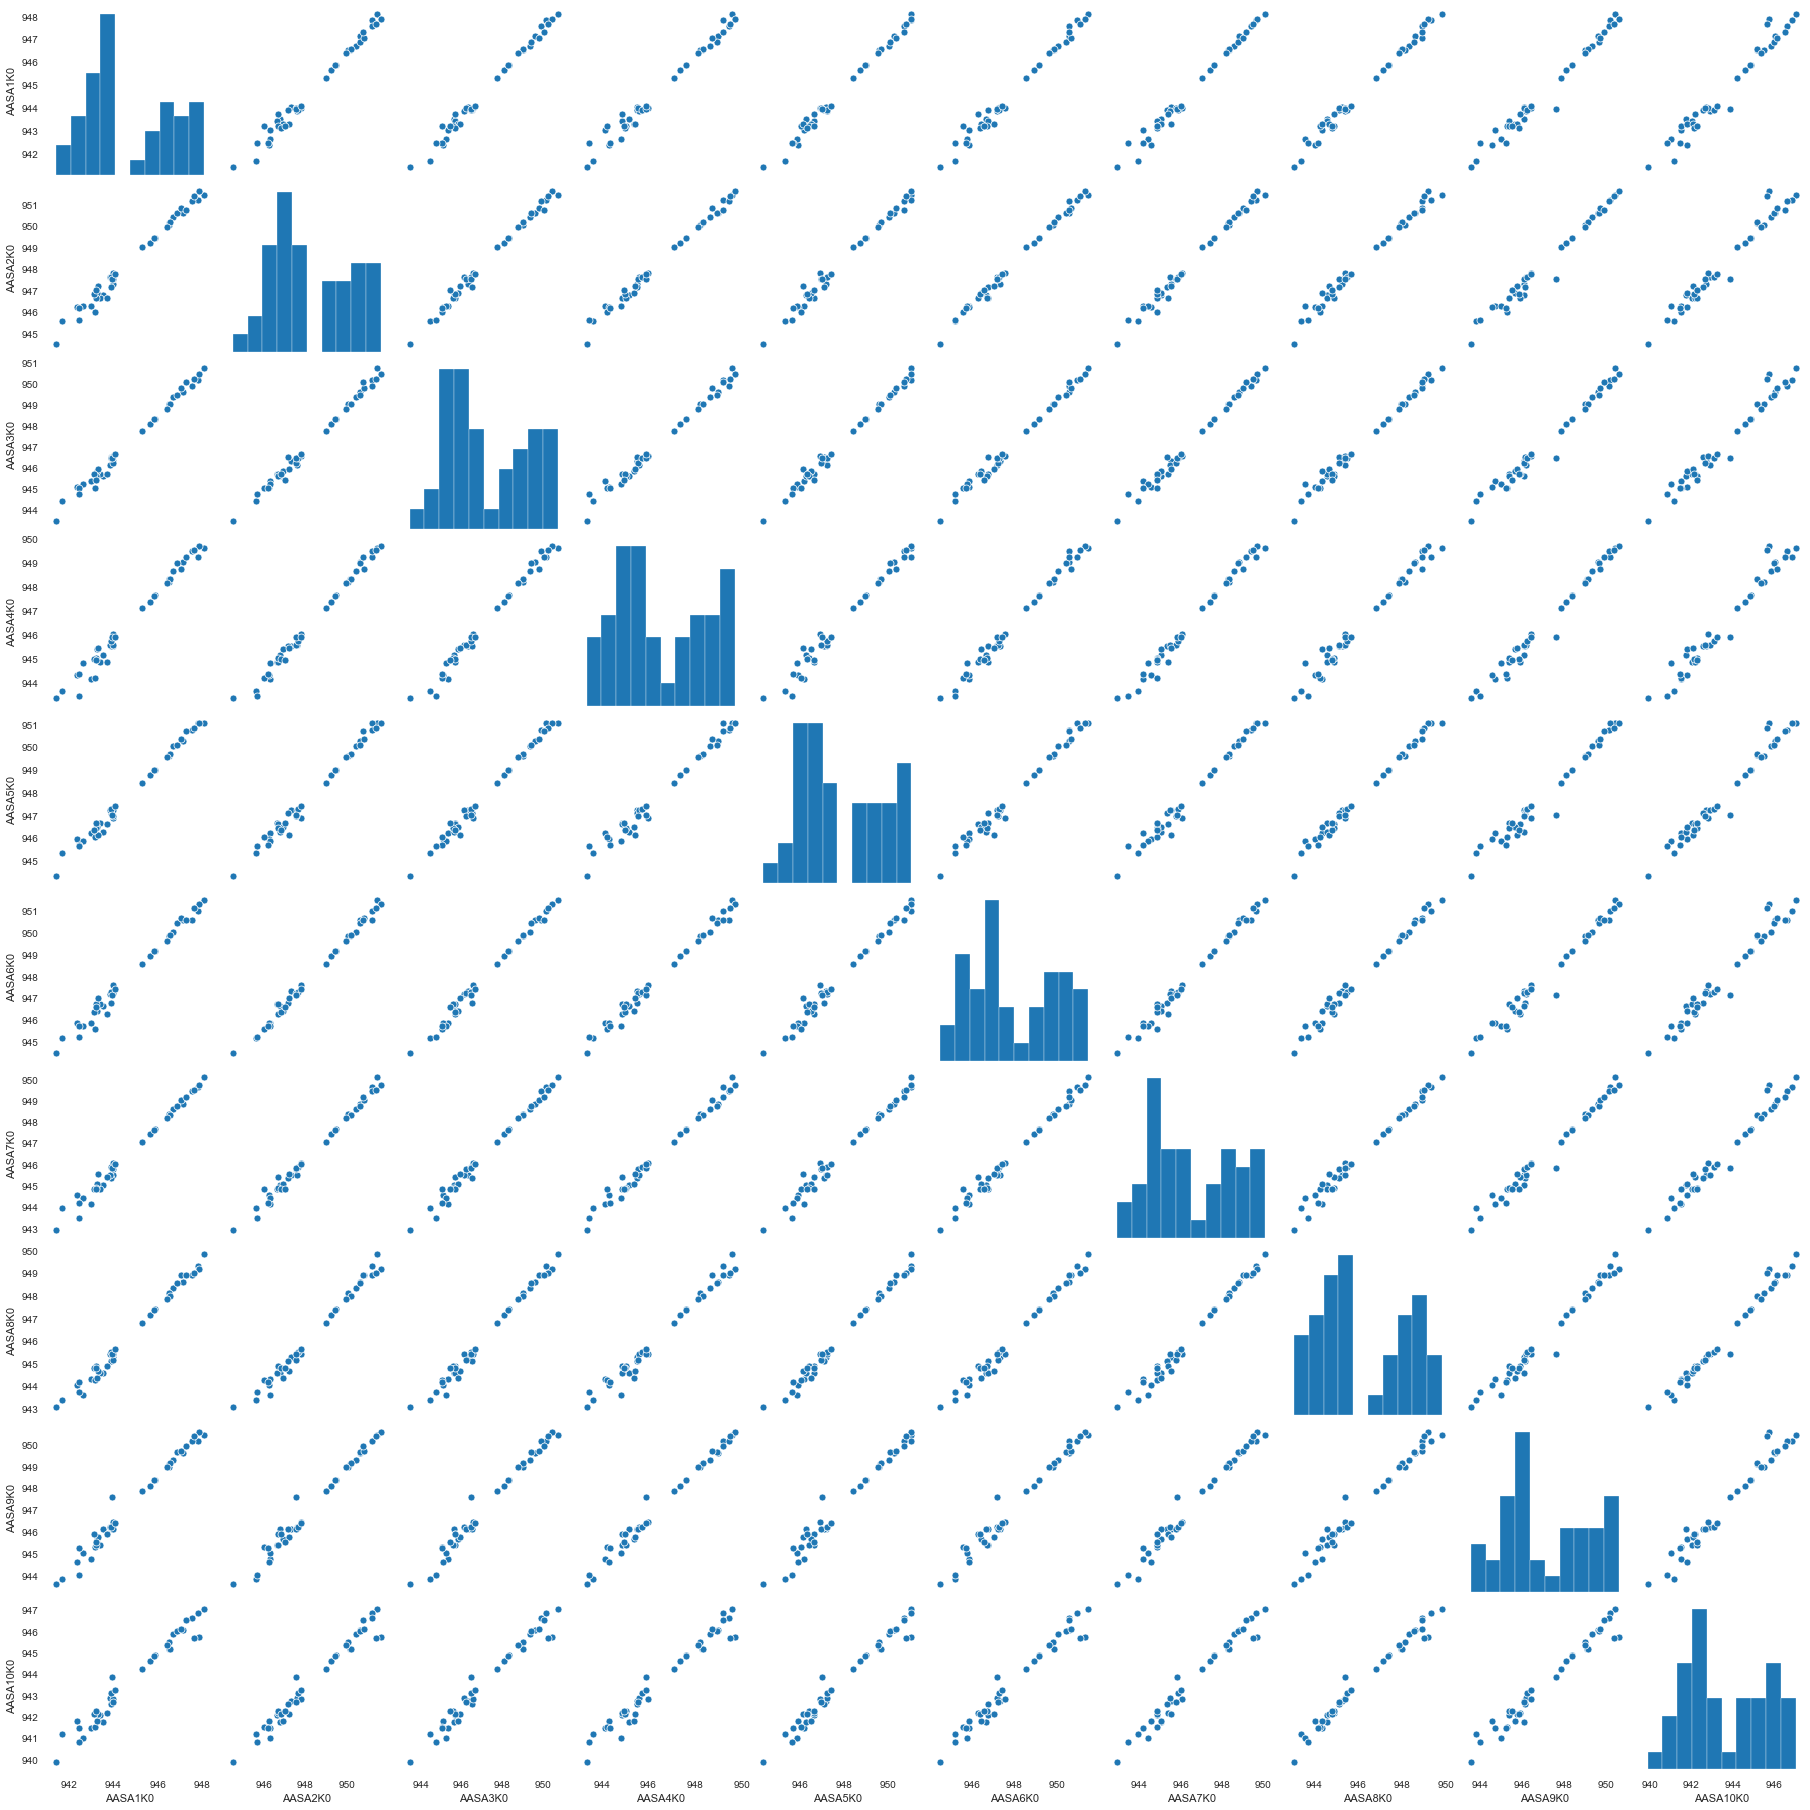

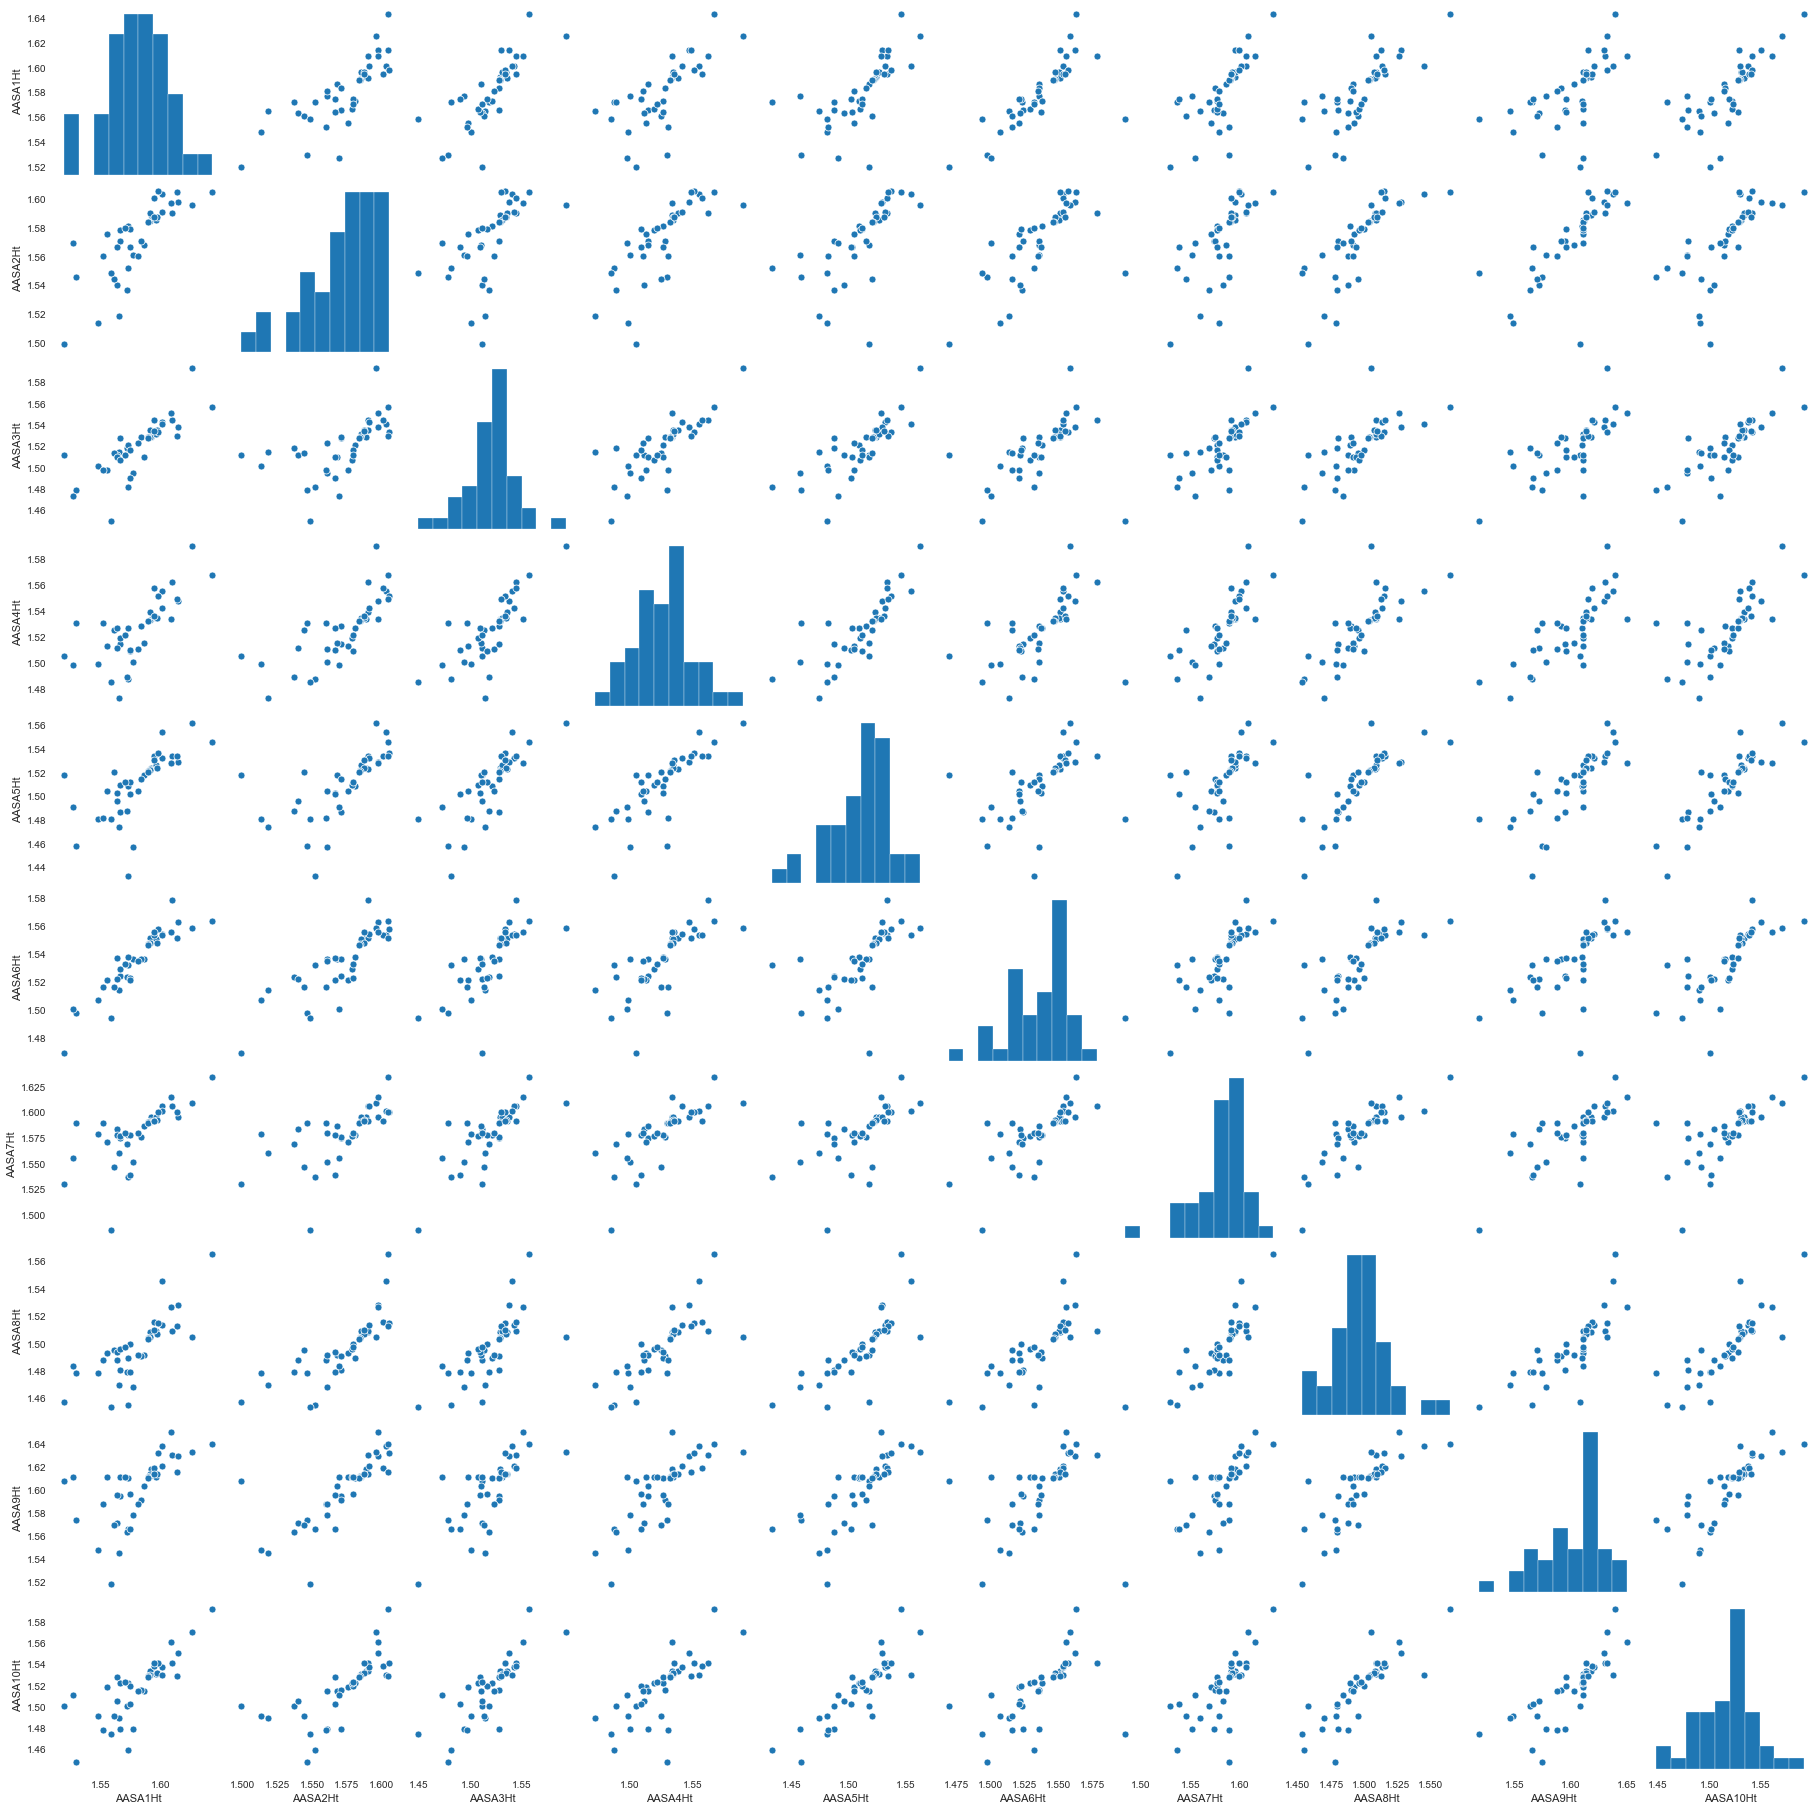

In [264]:
for i in range(48):
    sns_plot = sns.pairplot(p1STN.iloc[:, 10 * i + 2: 10 * i + 12])
    sns_plot.savefig(str(i)+".png")

### Dimensionality reduction

480 columns are naturally difficult to analyze in detail. That's why it is better to reduce the amount of data we are exploring. There's no prior knowledge that could make us choose some descriptors, so we're going to apply some feature selection algorithm. It is important to mention that, because data is so hard to collect, it is desirable to being able to build predictive models using descriptors calculated from only a subset of protein properties. That's also why feature extraction approaches like PCA are not suitable in this case.

We're using [ReBATE](https://epistasislab.github.io/scikit-rebate/), a package that contains scikit-learn compatible implementations of some Relief base feature selection algorithms, which are used in bioinformatics.

In [214]:
def select_subset_of_features_SURF(df, n_features):
    features_importance = calculate_features_importance(df, n_features)
    selected_features = select_n_most_important_features(features_importance, n_features)
    filtered_df = filter_selected_columns(df, selected_features)
    return filtered_df

def calculate_features_importance(df, n_features):
    features, target = split_features_and_target(df)
    
    rlf = SURF(n_features_to_select=n_features)
    rlf.fit(features, target)
    
    return pd.DataFrame({'feature_name':df.iloc[:, 2:].columns, 
                         'importance': rlf.feature_importances_})

def select_n_most_important_features(features_importance, n_features):
    return features_importance.sort_values(by='importance', ascending=False).head(n_features)['feature_name'].tolist()

def filter_selected_columns(df, columns):
    selected = ['id', 'stability']
    selected.extend(columns)
    return df[selected]

#Returns descriptors and target values as numpy arrays
def split_features_and_target(df):
    features = df.iloc[:, 2:].to_numpy()
    target =  df.iloc[:,1].to_numpy()
    return features, target


In [218]:
#Discards descriptors that are highly correlated at least with one other descriptor.
#The threshold is an absolute Pearson's r greater than 0.99 
def discard_highly_correlated_descriptors(df):
    
    #Calculates the absolute Pearson's r correlation matrix. Both -1 and 1 are highly correlated.
    correlations = df.corr().abs()
    
    #Gets the correlation matrix upper triangular.
    upper_corr = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
    
    #Discards the descriptors
    to_drop = [column for column in upper_corr.columns if any(upper_corr[column] > 0.99)]
    return df.drop(columns=to_drop)

#### Checking variables selected per dataset

In [219]:
reduced_p1STN = discard_highly_correlated_descriptors(p1STN)
reduced_p1STN = select_subset_of_features_SURF(p1STN, 40)

reduced_p4LYZ = discard_highly_correlated_descriptors(p4LYZ)
reduced_p4LYZ = select_subset_of_features_SURF(p4LYZ, 40)

reduced_p1BPI = discard_highly_correlated_descriptors(p1BPI)
reduced_p1BPI = select_subset_of_features_SURF(p1BPI, 40)

reduced_HLYZ = discard_highly_correlated_descriptors(HLYZ)
reduced_HLYZ = select_subset_of_features_SURF(HLYZ, 40)


In [237]:
def enumerate_selected_descriptors(df):
    for i,j in zip(np.linspace(start=1, stop=40, num= 40).astype('int'),df.columns[2:].to_list()):
        print(i,"&","$",j,"$", "\\\\")

In [241]:
enumerate_selected_descriptors(reduced_HLYZ)

1 & $ AASA8pK $ \\
2 & $ AASA2pK $ \\
3 & $ AASA5pK $ \\
4 & $ AASA7pK $ \\
5 & $ AASA4pK $ \\
6 & $ AASA9pK $ \\
7 & $ AASA1pK $ \\
8 & $ AASA10pK $ \\
9 & $ AASA3pK $ \\
10 & $ AASA6pK $ \\
11 & $ AASA2Ht $ \\
12 & $ AASA6f $ \\
13 & $ AASA6DGc $ \\
14 & $ AASA8Ht $ \\
15 & $ AASA2DGc $ \\
16 & $ AASA2TDSc $ \\
17 & $ AASA8TDSc $ \\
18 & $ AASA2V $ \\
19 & $ AASA2DHc $ \\
20 & $ AASA2DASA $ \\
21 & $ AASA2TDSh $ \\
22 & $ AASA10f $ \\
23 & $ AASA2DCph $ \\
24 & $ AASA6TDS $ \\
25 & $ AASA6Hnc $ \\
26 & $ AASA2s $ \\
27 & $ AASA6V $ \\
28 & $ AASA2m $ \\
29 & $ AASA6TDSh $ \\
30 & $ AASA6s $ \\
31 & $ AASA6DGh $ \\
32 & $ AASA6DH $ \\
33 & $ AASA3TDSh $ \\
34 & $ AASA6DASA $ \\
35 & $ AASA6V0 $ \\
36 & $ AASA8DCph $ \\
37 & $ AASA6Ht $ \\
38 & $ AASA6GhN $ \\
39 & $ AASA8Hnc $ \\
40 & $ AASA7an $ \\


### More on metadata

#### Target variable balance

Stability is a real-valued variable. However, there are implicit domain-dependant class labels. Negative values in stability are associated with **_destabilizing_** mutations. Positive values, including zero, are associated with **_non-destabilizing_** mutations.

In [78]:
def discretize_stability(df):
    return pd.cut(df['stability'],
           bins=[np.NINF, -0.0001,0, np.Inf], 
           labels=['Negative variation', 'No variation','Positive variation'], right=True)

Let's check data balance in relation to destabilizing and non-destabilizing mutations.

In [90]:
class_balance = pd.DataFrame({'1STN': discretize_stability(p1STN).value_counts(), 
'4LYZ': discretize_stability(p4LYZ).value_counts(),
'1BPI': discretize_stability(p1BPI).value_counts(),
 'HLYZ': discretize_stability(HLYZ).value_counts()})
class_balance.insert(loc=0, column='variation', value=class_balance.index.to_list())

In [245]:
class_balance.T

Negative variation  No variation  Positive variation
variation  Negative variation  No variation  Positive variation
1STN                       36             3                   3
4LYZ                       29             3                  19
1BPI                       46             5                   2
HLYZ                       89             3                  31

In [187]:
go.Pie(class_balance, values='1STN')

ValueError: The first argument to the plotly.graph_objs.Pie 
constructor must be a dict or 
an instance of :class:`plotly.graph_objs.Pie`

In [185]:
class_balance

variation  1STN  4LYZ  1BPI  HLYZ
Negative variation  Negative variation    36    29    46    89
No variation              No variation     3     3     5     3
Positive variation  Positive variation     3    19     2    31

In [92]:
fig = px.pie(class_balance, values='1STN', names='variation')
fig.show()

#### Stability anomalies

In [79]:
p4LYZ.loc[(p4LYZ['stability'] <= -3.07)]

id  stability     1AASAK0     2AASAK0     3AASAK0     4AASAK0  \
1  K13D      -6.70  901.851593  902.182295  901.203398  901.732368   
2  I55T      -4.96  901.278376  901.569245  900.624698  901.133852   
3  C94A      -4.78  898.328616  898.255801  897.316079  898.077359   
4  S91Y      -3.07  903.760737  904.349811  903.515194  903.791725   

      5AASAK0     6AASAK0     7AASAK0     8AASAK0  ...    1AASAf    2AASAf  \
1  905.939140  902.901285  900.955902  901.358982  ...  2.775194  2.968750   
2  905.302372  902.274015  900.275531  900.767660  ...  2.883721  2.960938   
3  901.943380  898.871917  896.616760  897.631979  ...  2.883721  2.960938   
4  908.121287  905.088430  903.209765  903.668648  ...  2.906977  3.023438   

     3AASAf    4AASAf  5AASAf    6AASAf    7AASAf    8AASAf    9AASAf  \
1  2.645669  3.023810   2.864  2.709677  3.178862  2.688525  3.041322   
2  2.614173  3.031746   2.912  2.750000  3.195122  2.827869  3.016529   
3  2.606299  3.039683   2.912  2.766129  3.195122  2.844262  3.016529   
4  2.669291  3.071429   2.968  2.830645  3.260163  2.877049  3.049587   

    10AASAf  
1  2.716667  
2  2.725000  
3  2.766667  
4  2.808333  

[4 rows x 482 columns]

In [80]:
p1BPI.loc[(p1BPI['stability'] < -5.0)]

id  stability     1AASAK0     2AASAK0     3AASAK0     4AASAK0  \
1  C30G      -8.74  892.276121  893.555935  896.830561  893.065004   
2  C30S      -8.00  895.472921  896.498082  899.918332  896.364960   
3  C30T      -7.81  896.971421  897.877214  901.365725  897.911815   
4  F45A      -6.90  888.870252  889.862030  894.656775  888.463251   
5  C30A      -6.14  890.611121  892.023567  895.222346  891.346276   
6  C30V      -5.95  896.294321  897.254051  900.711718  897.212865   
7  Y23A      -5.90  888.006417  889.405909  893.047571  889.829433   
8  N43G      -5.70  894.868597  894.921419  899.038111  895.727302   

      5AASAK0     6AASAK0     7AASAK0     8AASAK0  ...    1AASAf    2AASAf  \
1  888.212917  887.225872  885.778133  888.630016  ...  2.793103  3.210526   
2  891.440117  890.372136  889.212533  892.433875  ...  2.879310  3.228070   
3  892.952867  891.846947  890.822408  894.216933  ...  2.879310  3.228070   
4  884.921128  883.445502  881.592329  886.812573  ...  2.672414  3.122807   
5  886.532083  885.587192  883.989383  886.648839  ...  2.793103  3.210526   
6  892.269328  891.180551  890.094983  893.411255  ...  2.879310  3.228070   
7  884.382739  883.105004  882.052652  884.196392  ...  2.741379  3.157895   
8  890.522550  888.935589  888.209483  891.129980  ...  2.637931  3.017544   

     3AASAf    4AASAf    5AASAf    6AASAf    7AASAf    8AASAf  9AASAf  \
1  3.678571  3.072727  2.777778  2.849057  3.057692  2.784314    2.92   
2  3.714286  3.163636  2.814815  2.886792  3.096154  2.843137    3.06   
3  3.714286  3.163636  2.814815  2.886792  3.096154  2.843137    3.06   
4  3.535714  2.909091  2.740741  2.660377  2.942308  2.647059    3.02   
5  3.678571  3.072727  2.777778  2.849057  3.057692  2.784314    2.92   
6  3.714286  3.163636  2.814815  2.886792  3.096154  2.843137    3.06   
7  3.392857  3.090909  2.740741  2.622642  3.057692  2.568627    2.98   
8  3.571429  2.945455  2.777778  2.773585  3.019231  2.725490    2.90   

    10AASAf  
1  2.918367  
2  3.020408  
3  3.020408  
4  2.897959  
5  2.918367  
6  3.020408  
7  2.938776  
8  2.734694  

[8 rows x 482 columns]

#### Stability distribution comparison

In [55]:
fig = px.box(p1STN, y='stability',
             boxmode="overlay", points='all', title = "Stability 1STN", labels={'y':"Stability"})

fig.show()

In [59]:
fig = px.box(p4LYZ, y='stability', boxmode="overlay", points='all', title = "Stability 4LYZ"
             , labels={'y':"Stability"}, hover_data=['id'])

fig.show()

In [60]:
fig = px.box(p1BPI, y='stability', boxmode="overlay", points='all', title = "Stability 1BPI"
             , labels={'y':"Stability"}, hover_data=['id'])

fig.show()

In [61]:
fig = px.box(HLYZ, y='stability', boxmode="overlay", points='all', title = "Stability HLYZ", 
             labels={'y':"Stability"}, hover_data=['id'])

fig.show()

In [64]:
df =  pd.concat([pd.DataFrame({'dataset': ['1STN' for i in range(len(p1STN['stability']))], 'stability' : p1STN['stability']}),
          pd.DataFrame({'dataset': ['4LYZ' for i in range(len(p4LYZ['stability']))], 'stability' : p4LYZ['stability']}),
          pd.DataFrame({'dataset': ['1BPI' for i in range(len(p1BPI['stability']))], 'stability' : p1BPI['stability']}),
        pd.DataFrame({'dataset': ['HLYZ' for i in range(len(HLYZ['stability']))], 'stability' : HLYZ['stability']})])
fig = px.box(df, y="stability", facet_col="dataset", color="dataset",
             boxmode="overlay", points='all', title='Stability comparison between datasets')

fig.show()

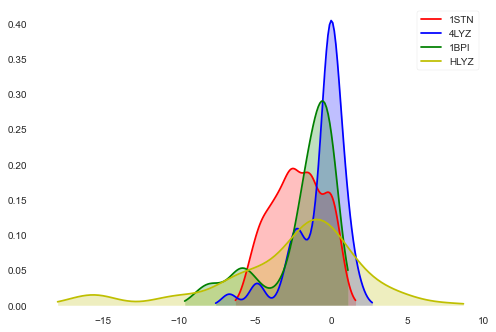

In [90]:
sns.kdeplot(p1STN['stability'], shade=True, color="r", bw=0.3, label='1STN')
sns.kdeplot(p4LYZ['stability'], shade=True, color="b", bw=0.3 , label='4LYZ')
sns.kdeplot(p1BPI['stability'], shade=True, color="g", bw=0.3, label='1BPI')
sns.kdeplot(HLYZ['stability'], shade=True, color="y", bw=0.3, label='HLYZ')

#### Descriptors distribution

In [ ]:


n_rows = len(reduced_p1STN)
n_cols = len(reduced_p1STN.columns) - 2
count = 0
col_num = 1

plt.subplots(n_rows, n_cols )
for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, count+1)
        sns.boxplot(df.iloc[:, col_num], orient='vertical')
        if col_num < df.shape[1] :
            count += 1
            col_num += 1

plt.show()

IndexError: single positional indexer is out-of-bounds

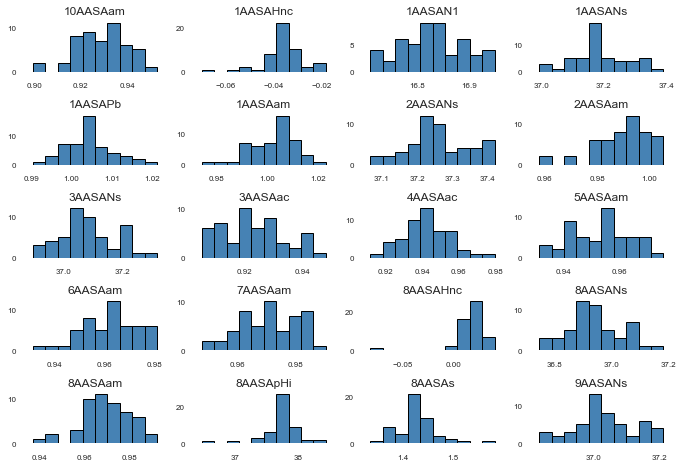

In [505]:
filtered_p4LYZ.iloc[:,2:].hist(color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

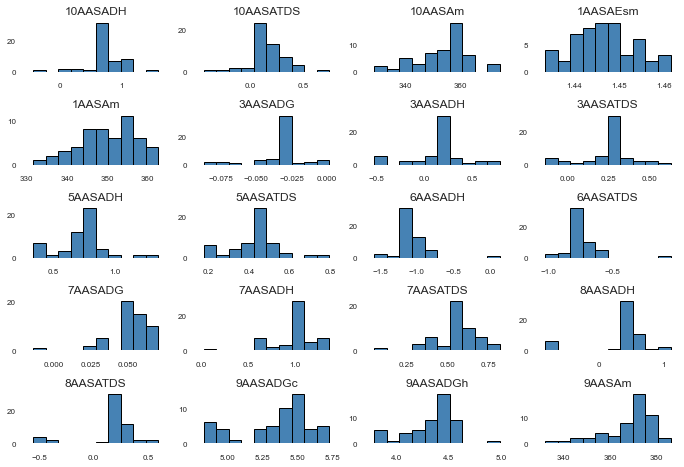

In [506]:
filtered_p1BPI.iloc[:,2:].hist(color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

#### Descriptors correlation

Checking the correlation of descriptors. If two predictors are highly correlated with each other, keeping both could imply a data redundancy.

In [275]:
sns.heatmap(p1STN[,:columns].corr(method='pearson').abs())

SyntaxError: invalid syntax (<ipython-input-275-844d9672db26>, line 1)

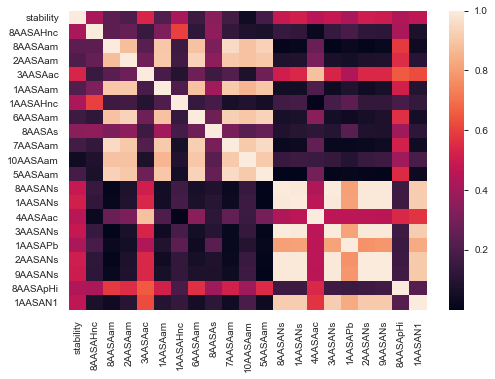

In [499]:
sns.heatmap(filtered_p4LYZ.corr(method='pearson').abs())

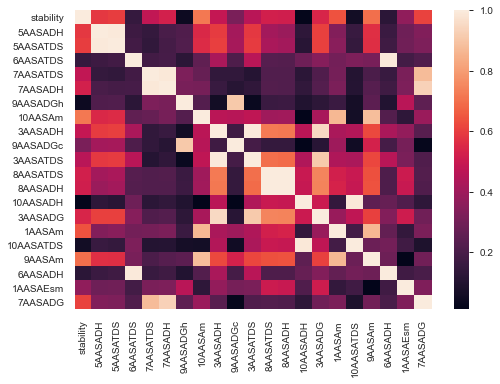

In [500]:
sns.heatmap(filtered_p1BPI.corr(method='pearson').abs())

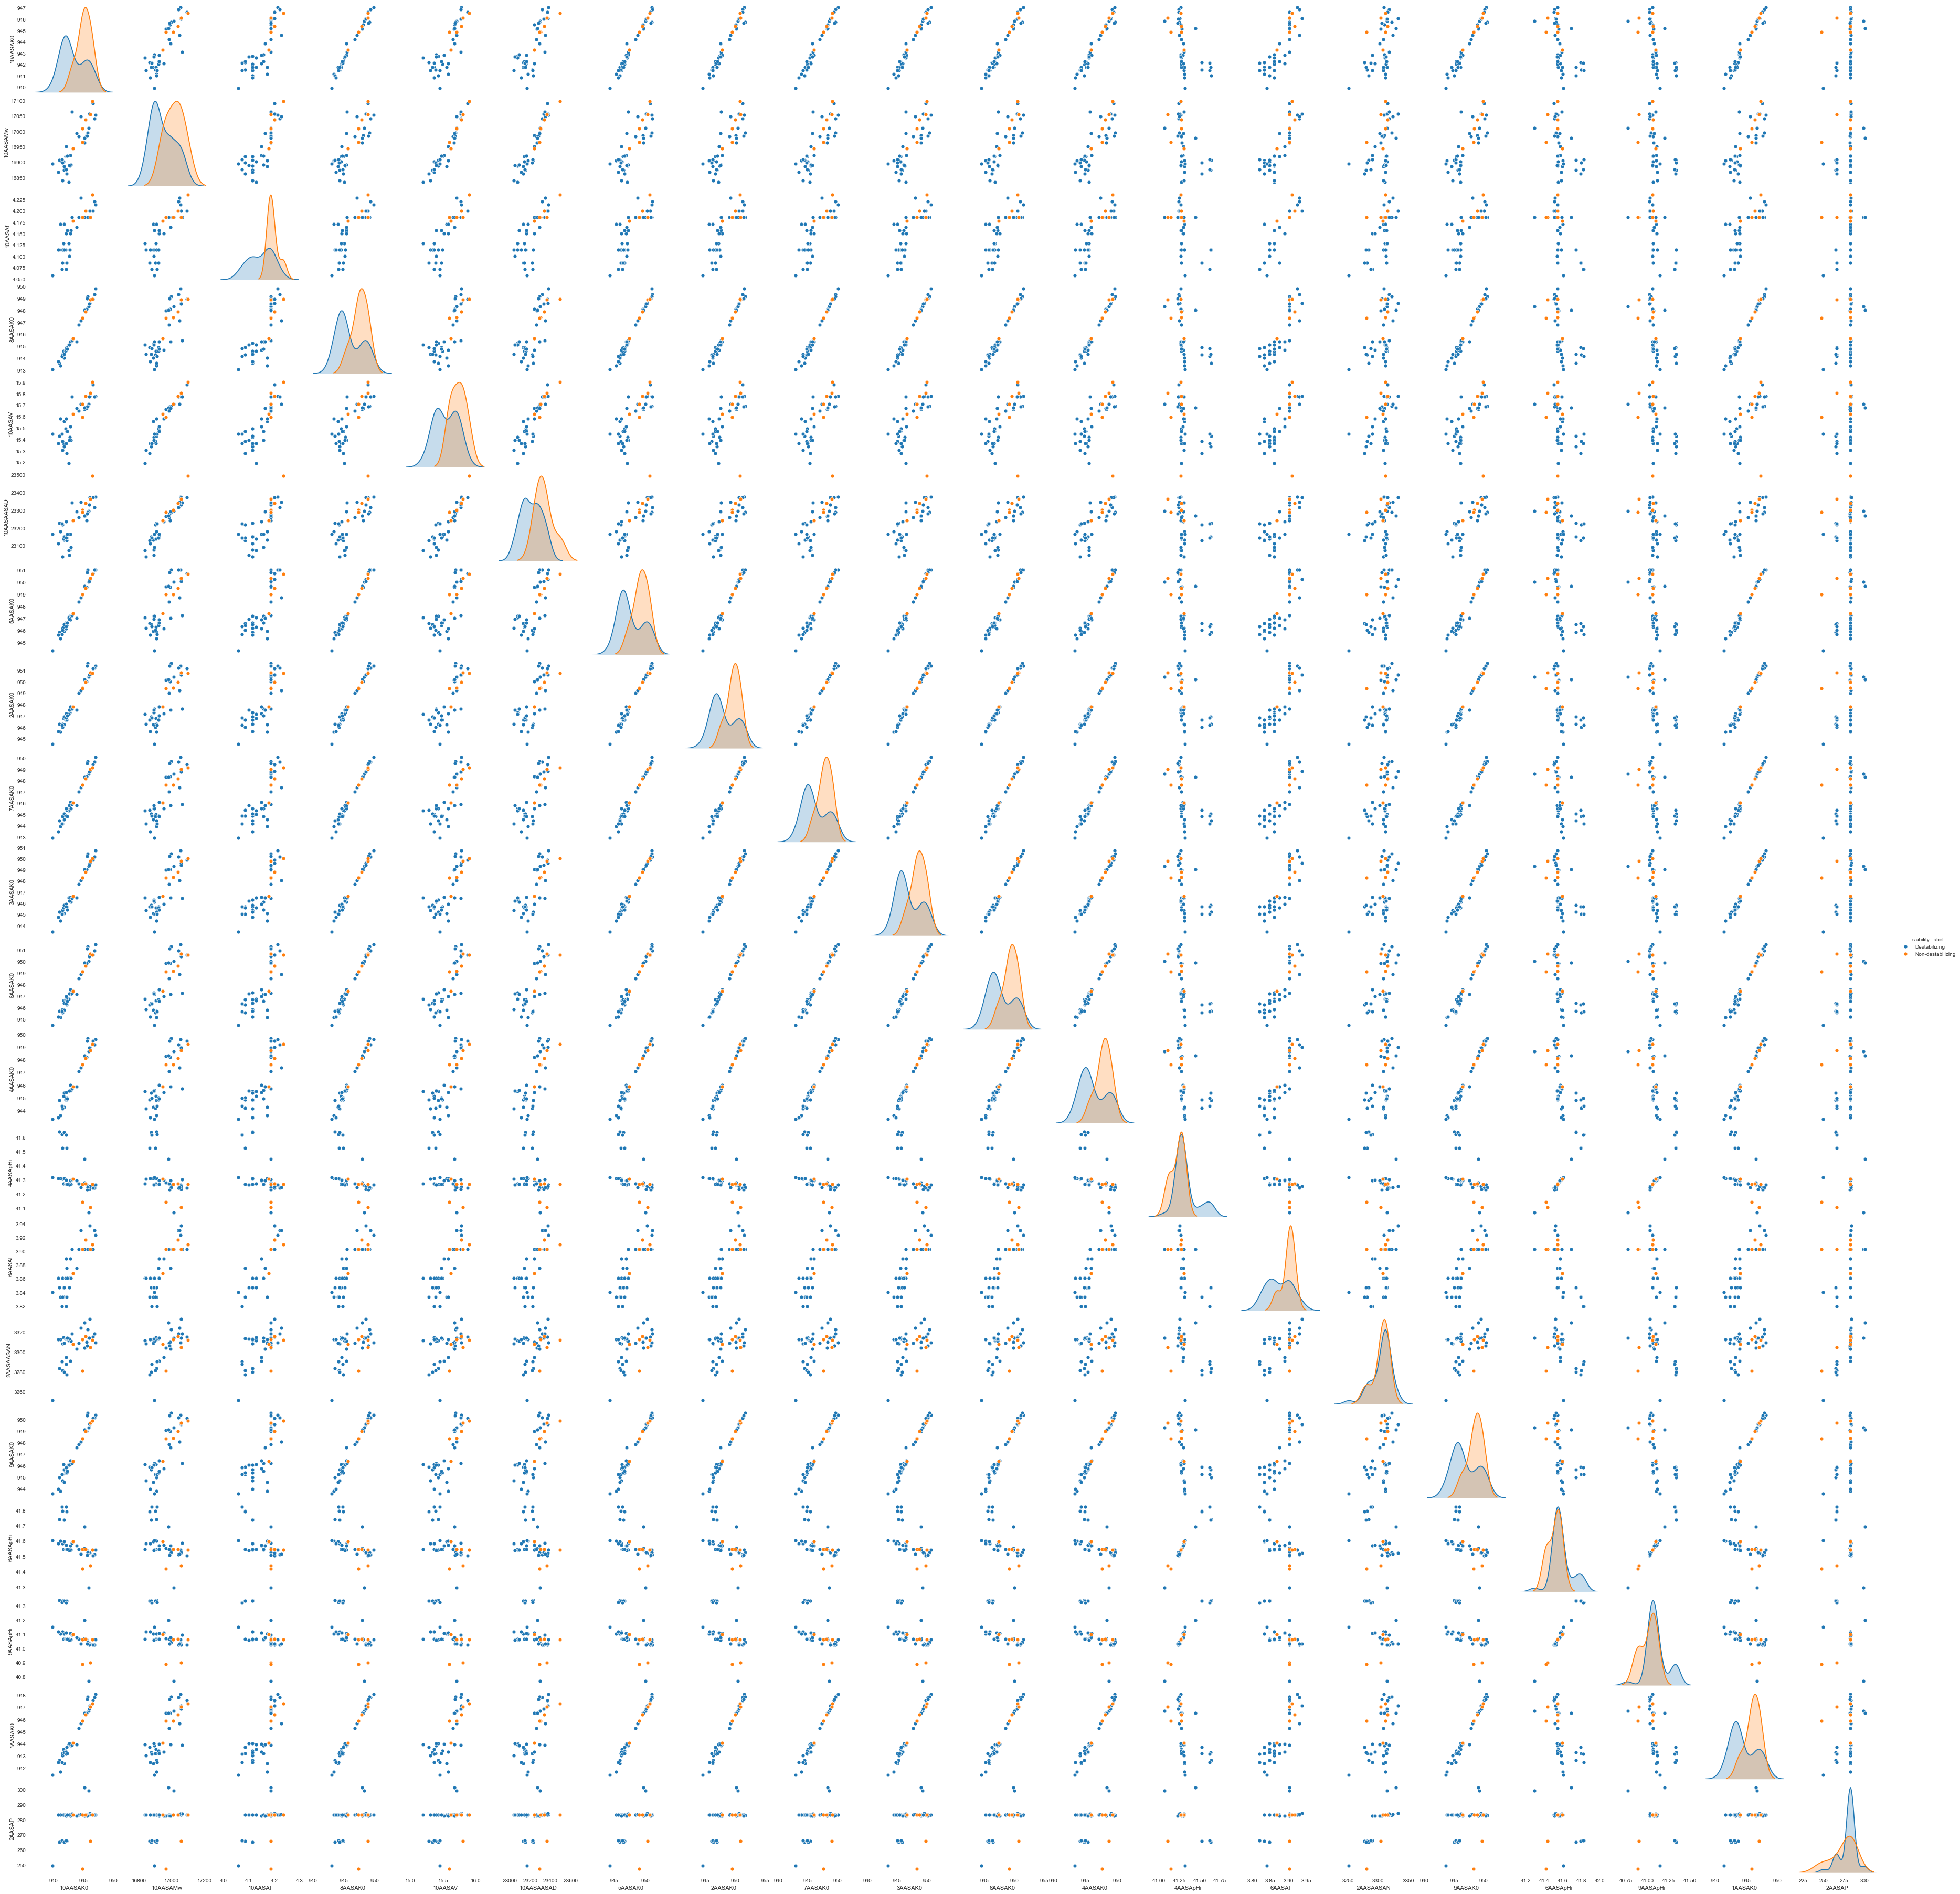

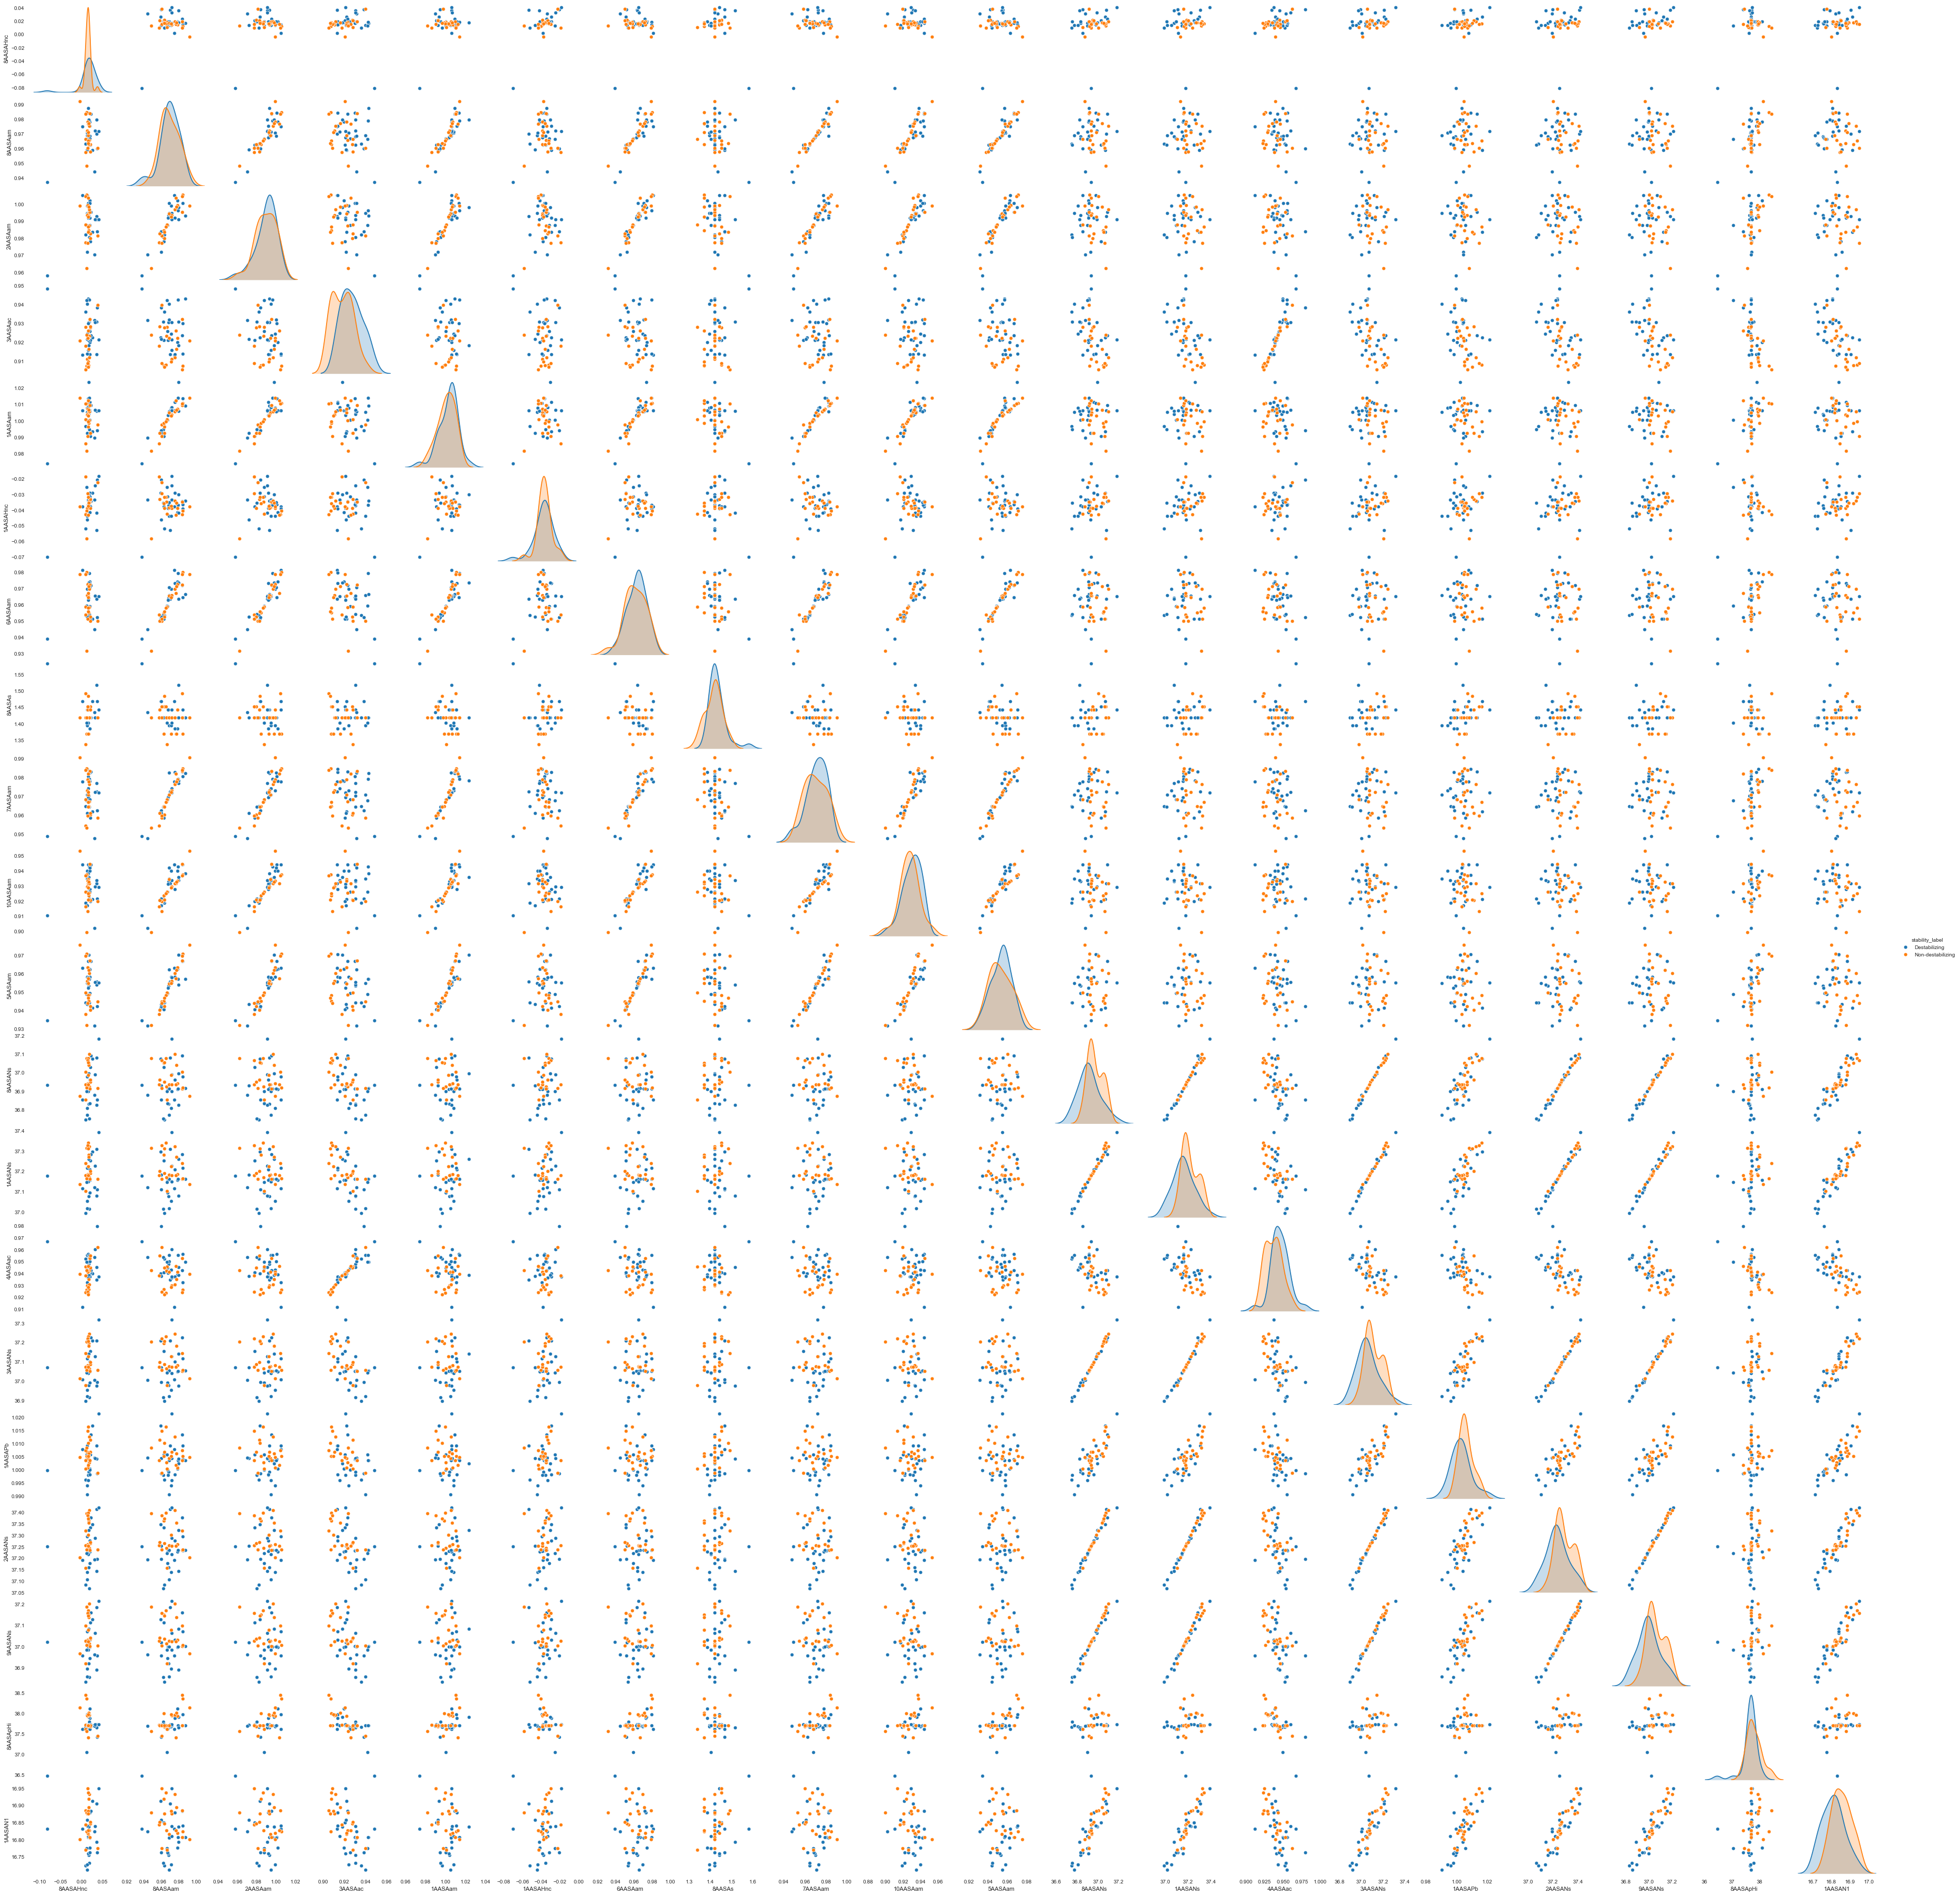

In [602]:
sns.pairplot(filtered_p4LYZ.iloc[:,2:].assign(stability_label = discretize_stability(filtered_p4LYZ)), hue="stability_label")

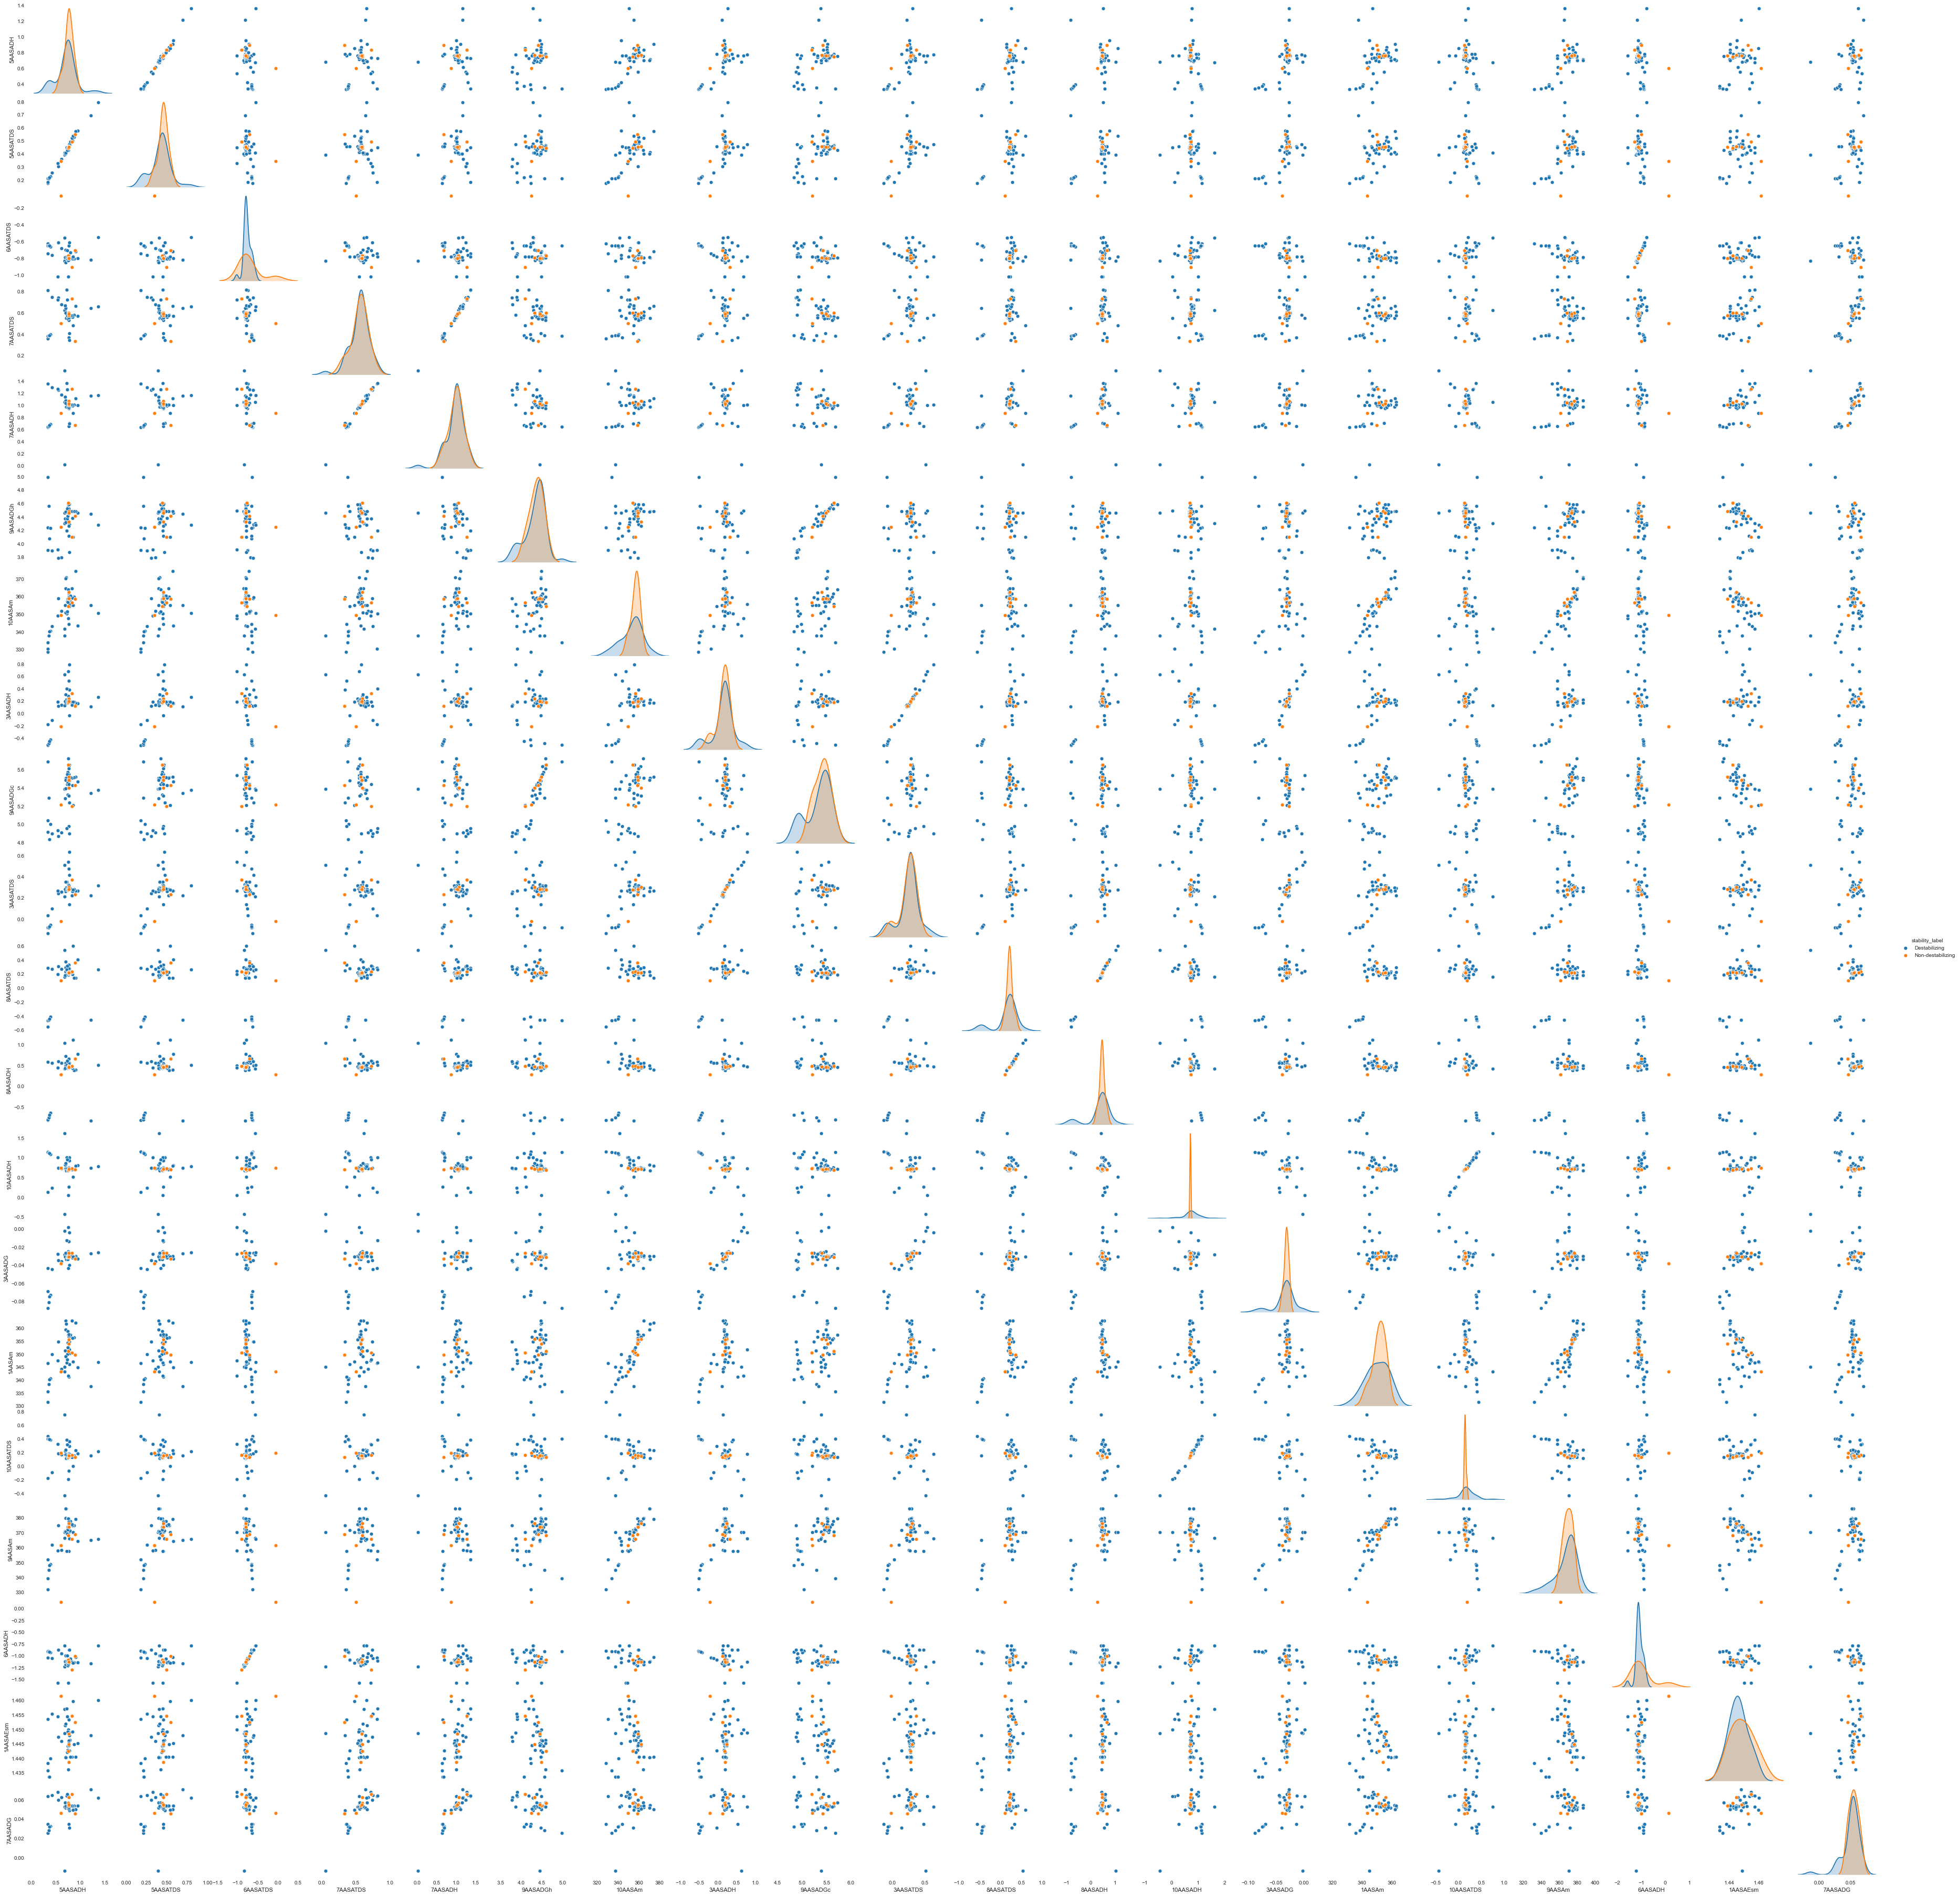

In [600]:
sns.pairplot(filtered_p1BPI.iloc[:,2:].assign(stability_label = discretize_stability(filtered_p1BPI)), hue="stability_label")

### Data reduction

In order to inspect data in more detail, we first need to find a way to reduce the 480 columns. When collecting data, each descriptor of a protein is measured 10 times. So, we calculate the mean of the 10 measurements for each of the descriptors. Thus, our data of 480 columns is reduced to only 48. The 10 measurements for a descriptor are registered in ordered and contiguous columns of the dataset. An example is the first descriptor *_AASAK0_*, which measurements are *_1AASAK0_*, *_2AASAK0_*, ..., *_10AASAK0_*. All 3 datasets share the same format. The following functions are used to average the descriptors measurements.

The following code reduces the data to 50 columns, including stability and protein name.

### Data transformation

#### Descriptor aggregation

Here some descriptor aggregation is performed as an alternative to feature selection.

In [2]:
def aggregate_properties_descriptors(df, method):
    #Creates a new dataframe from original 'name' and 'stability' columns
    new_df = df.loc[:, ['id', 'stability']]
    
    #Creates a dictionary that maps property names to its descriptors aggreation.
    aggregations = {property_name: descriptors_aggregation for property_name, descriptors_aggregation in aggregate(df, method)}
    
    #Creates columns for each property in the new dataframe.
    return new_df.assign(**aggregations)

def aggregate(df, method):
    for i in range(48): #For each one of the 48 descriptors
        
        # Extracts a dataframe containing descriptors associated with property i
        descriptors = df.iloc[:, 10 * i + 2: 10 * i + 12]
        property_name = descriptors.columns[1][1:]
        
        if(method == 'mean'):
            aggregation = aggregate_using_mean(descriptors)
        elif(method == 'pca'):
            aggregation = aggregate_using_pca(descriptors)
        elif(method == 'rel_std'):
            aggregation = aggregate_using_rel_std(descriptors)
        else:
            aggregation= np.array([])
        
        yield property_name, aggregation
    

def aggregate_using_rel_std(descriptors):
    return (descriptors.std(axis ='columns').to_numpy() / descriptors.mean(axis ='columns').to_numpy())*100

def aggregate_using_pca(descriptors):
    pca = PCA(n_components=1)
    return pca.fit_transform(preprocessing.scale(descriptors)).flatten()

def aggregate_using_mean(descriptors):
    return descriptors.mean(axis ='columns').to_numpy()

In [3]:
transformed_p1STN = aggregate_properties_descriptors(p1STN, method='pca')
transformed_p4LYZ = aggregate_properties_descriptors(p4LYZ, method='pca')
transformed_p1BPI = aggregate_properties_descriptors(p1BPI, method='pca')
transformed_HLYZ = aggregate_properties_descriptors(HLYZ, method='pca')

NameError: name 'p1STN' is not defined

#### Feature extraction using PCA

In [227]:
def transform_using_pca(df):
    new_df = df.iloc[:,0:2]
    pca = PCA(n_components=30)
    transformed_features = pca.fit_transform(preprocessing.scale(df.iloc[:, 2:]))
    
    return new_df.join(pd.DataFrame(transformed_features, columns=['PC' + str(i) for i in range(30)]))

In [229]:
transformed_p1STN = transform_using_pca(p1STN)
transformed_p4LYZ = transform_using_pca(p4LYZ)
transformed_p1BPI = transform_using_pca(p1BPI)
transformed_HLYZ = transform_using_pca(HLYZ)

### Exporting to preprocessed data to CSV

It is convenient to export the data already preprocessed so it can be used later for EDA and Predictive Modeling 

In [198]:
processed_data_path = "../../data/processed/"
transformed_data_path = processed_data_path + "transformed/"
original_data_path = processed_data_path + "original/"

In [232]:
transformed_p1STN.to_csv(path_or_buf= transformed_data_path + 'pca/' + 'p1STN.csv', index=False)
transformed_p4LYZ.to_csv(path_or_buf= transformed_data_path + 'pca/' + 'p4LYZ.csv', index=False)
transformed_p1BPI.to_csv(path_or_buf= transformed_data_path + 'pca/' + 'p1BPI.csv', index=False)
transformed_HLYZ.to_csv(path_or_buf= transformed_data_path + 'pca/' + 'HLYZ.csv', index=False)

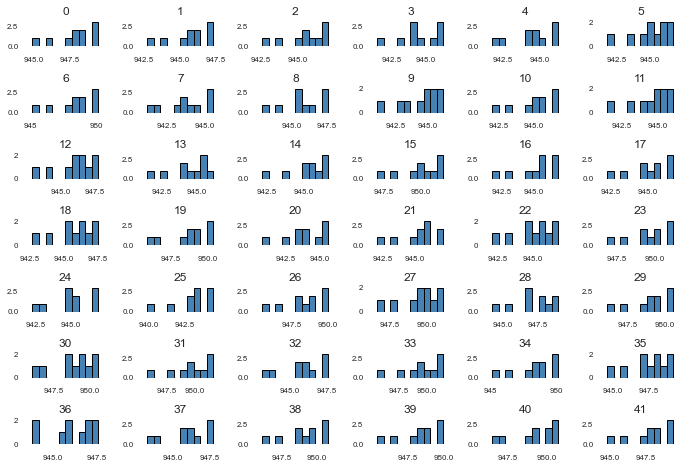

In [83]:
p1STN.iloc[:,2:12].T.hist(color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

To choose a similarity metric, we should determine before hand if the data is continuous or discrete.

In [294]:
print((p1STN.nunique() < len(p1STN)*0.50).sum())
print((p4LYZ.nunique() < len(p4LYZ)*0.50).sum())
print((p1BPI.nunique() < len(p1BPI)*0.50).sum())
print((HLYZ.nunique() < len(HLYZ)*0.50).sum())

20
24
20
30


There are a few descriptors which unique values are less than a 50% of the total. So it is safe to assume that data is continuous